# Discussion with Dan 

In [1]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 48


In [2]:
import os
os.getenv('SLURM_CPUS_PER_TASK')

'48'

In [3]:
from GP_recovery import *

2023-05-11 00:36:40.938647: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/lib
2023-05-11 00:36:40.969204: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/lib
2023-05-11 00:36:40.970402: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/jul

In [4]:
Nr = 20
t = np.linspace(0, 2000, 2001)
# t = np.linspace(0, 700, 701)
gp = GaussianProcess(kernel, t)
y = gp.sample(jax.random.PRNGKey(4), shape=(Nr,))
# y = y[0,:]
t.shape, y.shape

((2001,), (20, 2001))

### Periodogram may not be indicative

In [5]:
sigma = []
for i in range(N):
    fre = nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon
    sigma.append(gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig))
sigma = np.array(sigma)

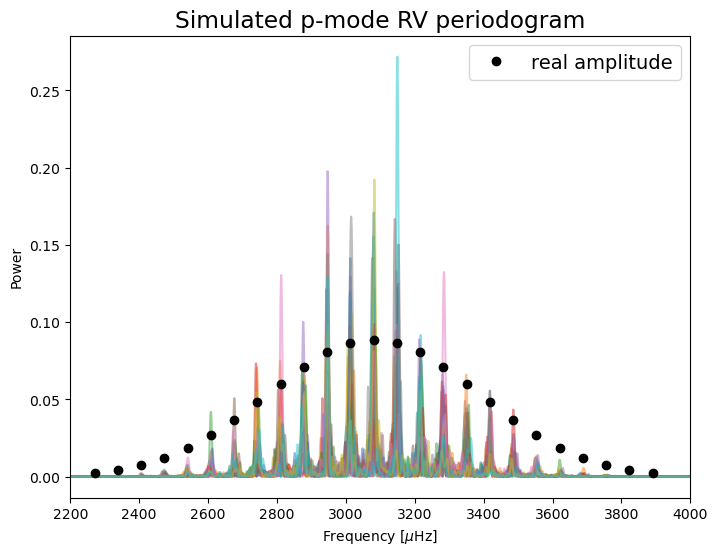

In [6]:
from astropy.timeseries import LombScargle

plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

for i in range(Nr):
    frequency, power = LombScargle(t*60, y[i,:]).autopower(samples_per_peak=10)
    frequency *= 1e6 # microHz
    idx = (frequency<5000) & (frequency>150)
    plt.plot(frequency[idx], power[idx], alpha=0.5)

sigma = []
fre = []
for i in range(N):
    fre.append(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)
    sigma.append(gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig))
fre = np.array(fre)
sigma = np.array(sigma)
plt.plot(fre, sigma/sum(sigma), 'ko', label='real amplitude')

plt.ylabel('Power')
# plt.xlim([2400,3800])
plt.xlim([2200,4000])
# plt.ylim([0,0.0004])
plt.title('Simulated p-mode RV periodogram')
plt.xlabel('Frequency [$\mu$Hz]')
# plt.savefig('Figure/SONG solar RV Periodogram.png')
plt.legend()
plt.show()

### true kernel and sample covariance

In [7]:
true_cov = kernel(t, t[:1])

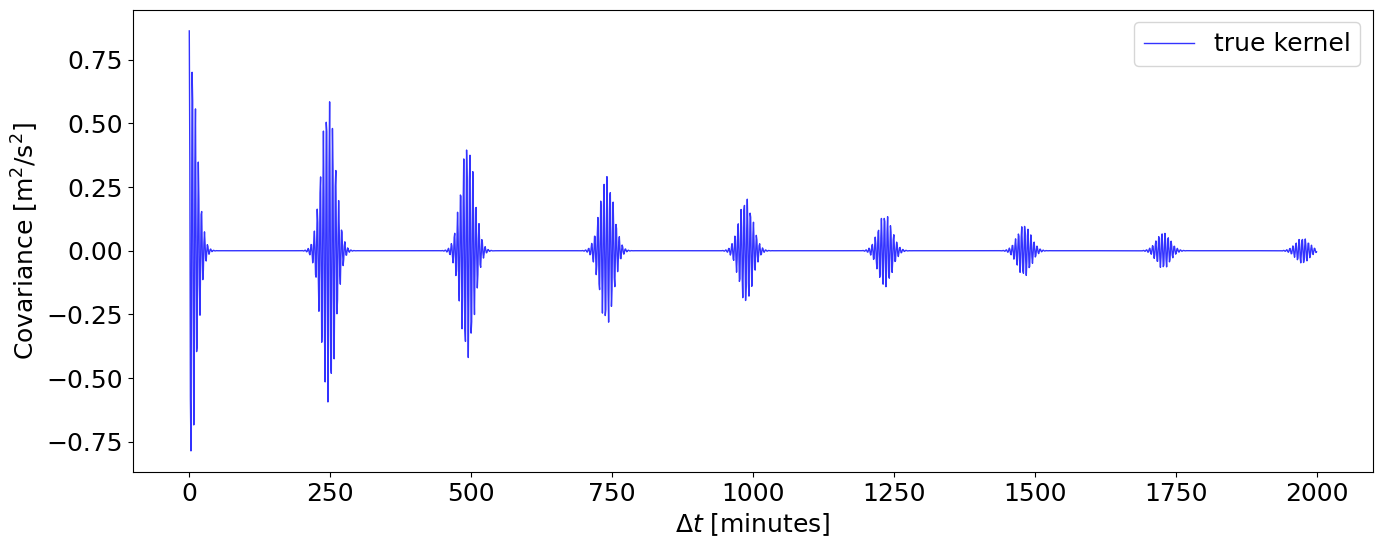

In [8]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(t, true_cov, lw=1, color='b', alpha=0.8, label='true kernel')
# plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.legend()
plt.show()

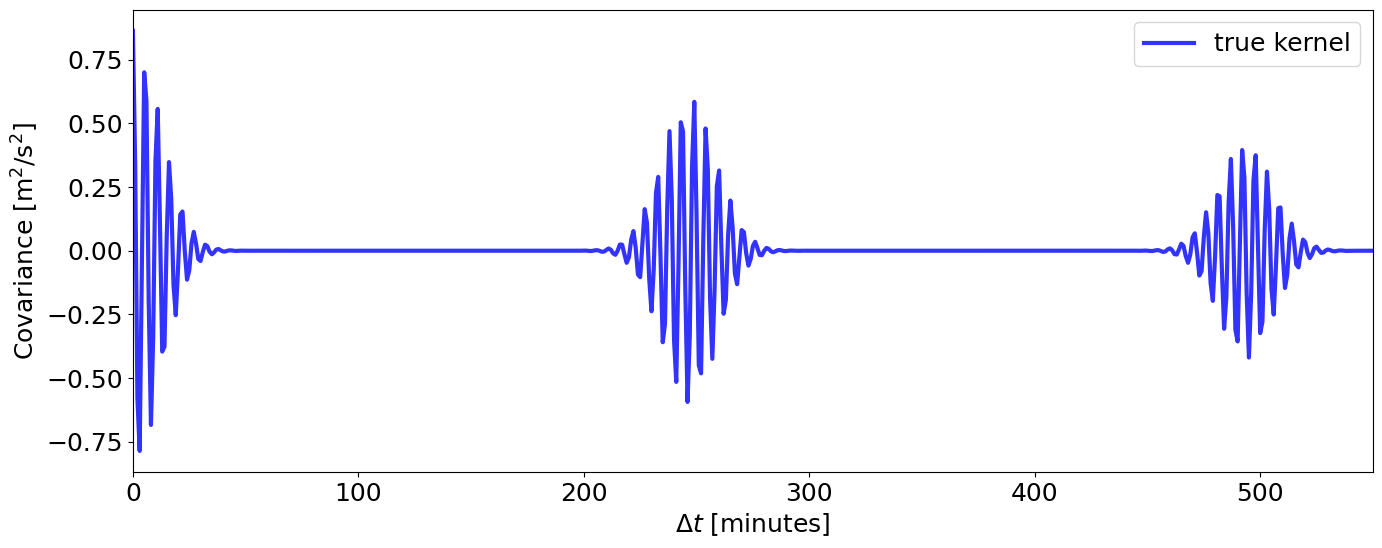

In [9]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(t, true_cov, lw=3, color='b', alpha=0.8, label='true kernel')
# plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.xlim([0,550])
plt.legend()
plt.show()

In [10]:
y.shape


(20, 2001)

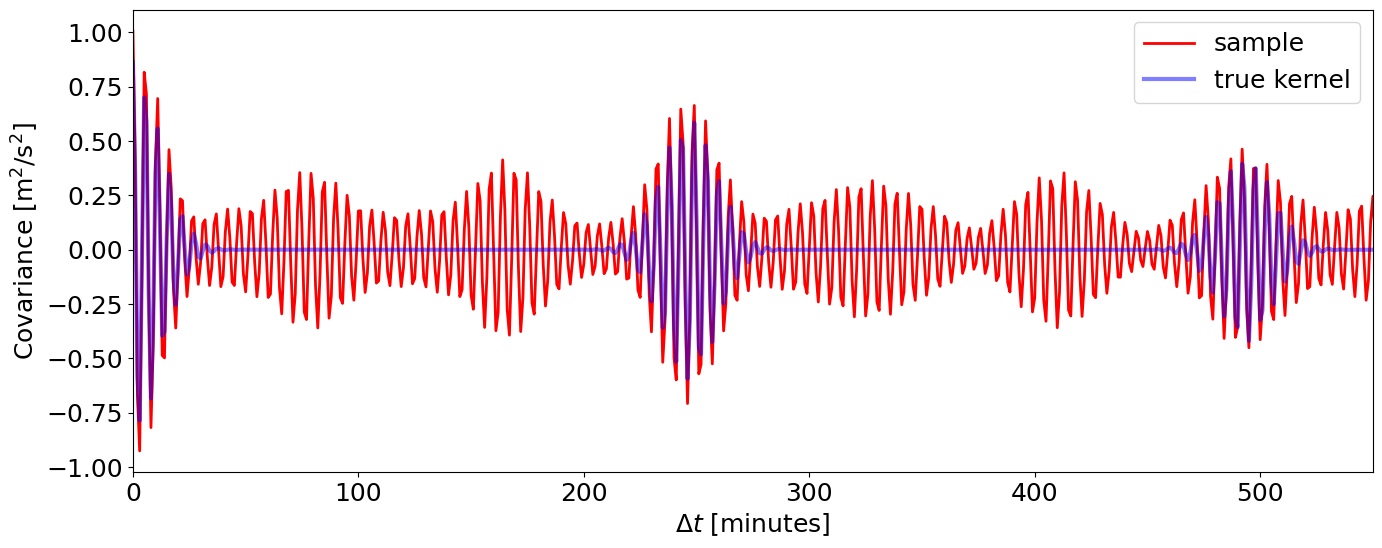

In [11]:
ACF_stack = np.array([]).reshape(0,2001)
import statsmodels.api as sm
for i in range(Nr):
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(16, 6))
    ACF = sm.tsa.acovf(y[i,:], fft=True)
    ACF_stack = np.vstack((ACF_stack, ACF))
    plt.plot(t, ACF, 'r', lw=2, label='sample')
    plt.plot(t, true_cov, lw=3, color='b', alpha=0.5, label='true kernel')
    plt.xlabel(r'$\Delta t$ [minutes]')
    plt.ylabel(r'Covariance [m$^2$/s$^2$]')
    plt.xlim([0,550])
    plt.legend()
    plt.savefig('./Figure/GP_recovery_run-19_covariance/' + str(i) + '.png')
    if i != (Nr-1):
        plt.close()

In [12]:
import cv2

img_array = []
for k in range(20):
    filename = './Figure/GP_recovery_run-19_covariance/' + str(k) + '.png'
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('./Video/GP_recovery_run-19_covariance.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


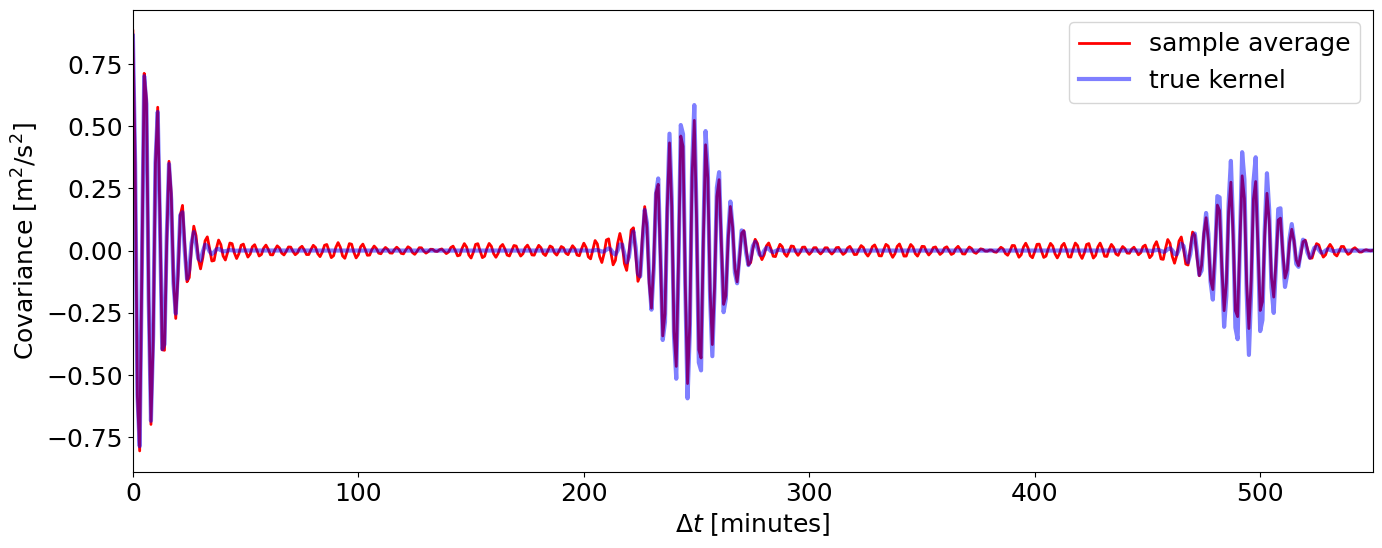

In [13]:
fig = plt.figure(figsize=(16, 6))
plt.plot(t, np.mean(ACF_stack, axis=0), 'r', lw=2, label='sample average')
plt.plot(t, true_cov, lw=3, color='b', alpha=0.5, label='true kernel')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.xlim([0,550])
plt.legend()
plt.savefig('./Figure/GP_recovery_run-19_covariance/cov_ave.png')

### Test the GP predicting power

#### Gapped data in middle### Test the GP predicting power

In [14]:
Nr = 1
t = np.linspace(0, 600, 601)
gp = GaussianProcess(kernel, t)
y = gp.sample(jax.random.PRNGKey(4), shape=(Nr,))
y = y[0,:]
t.shape, y.shape

((601,), (601,))

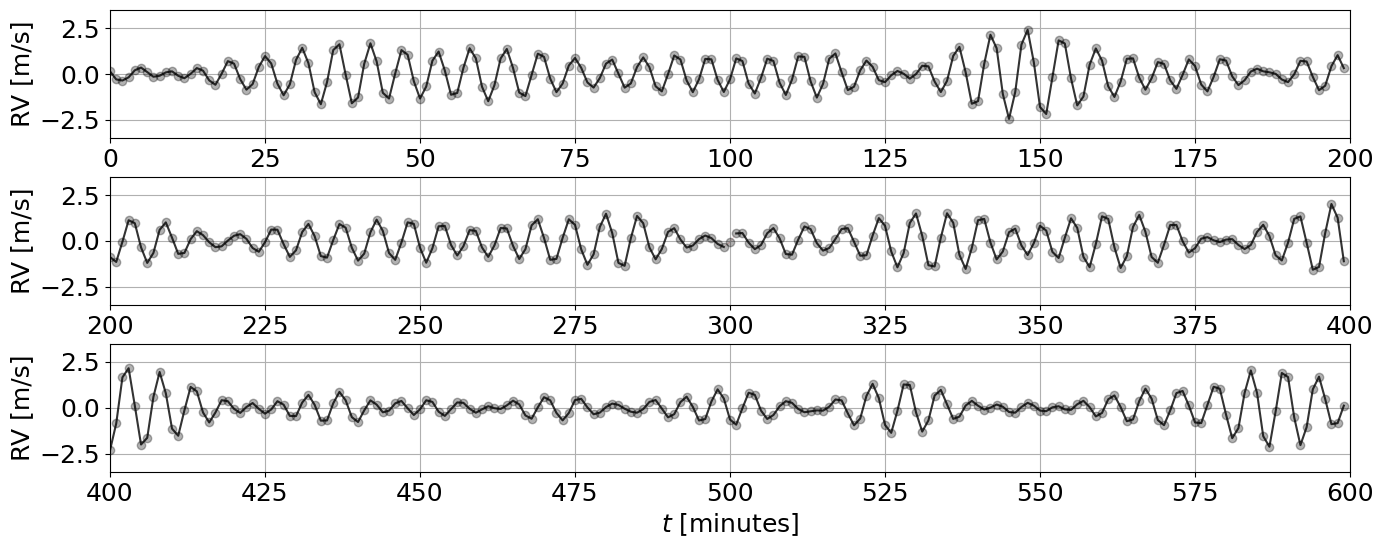

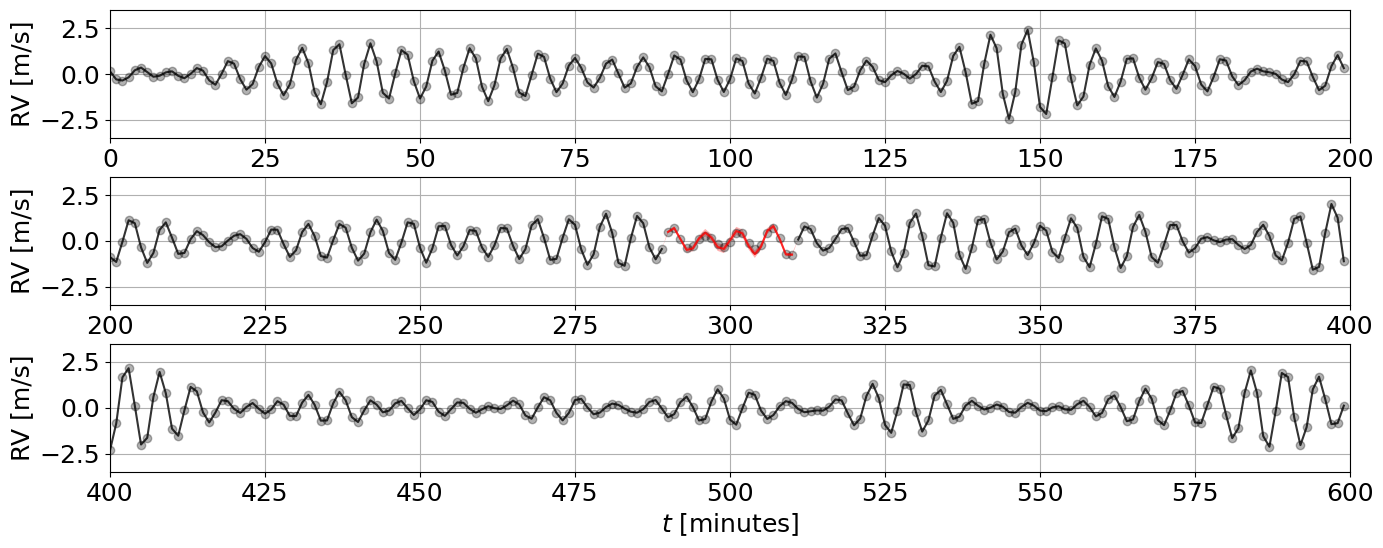

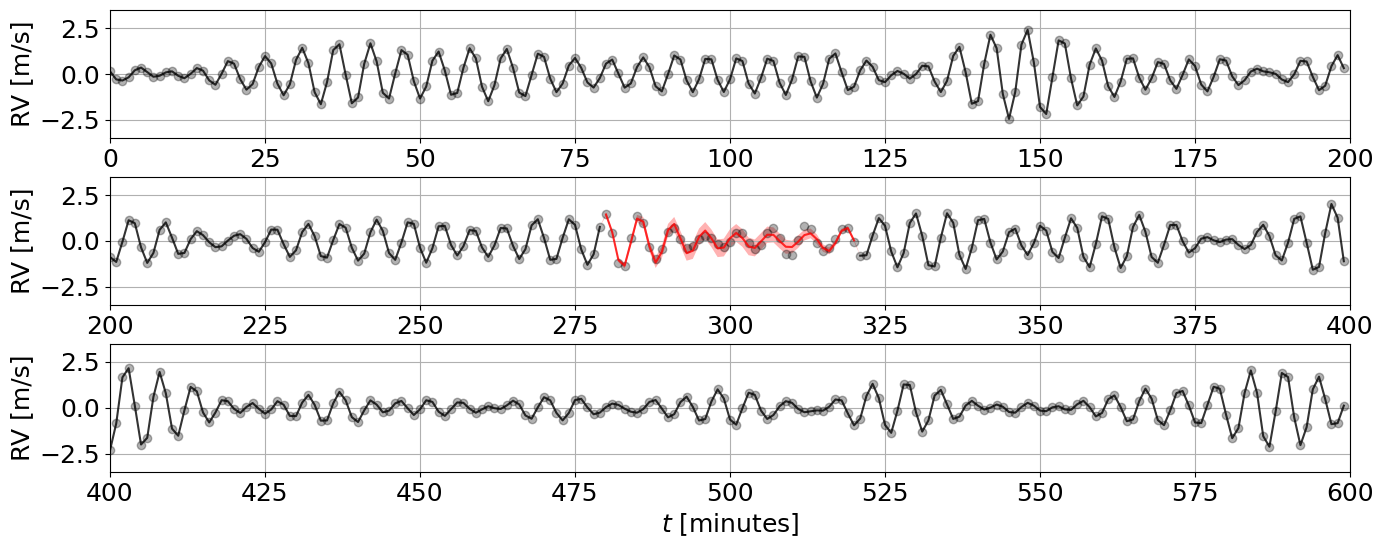

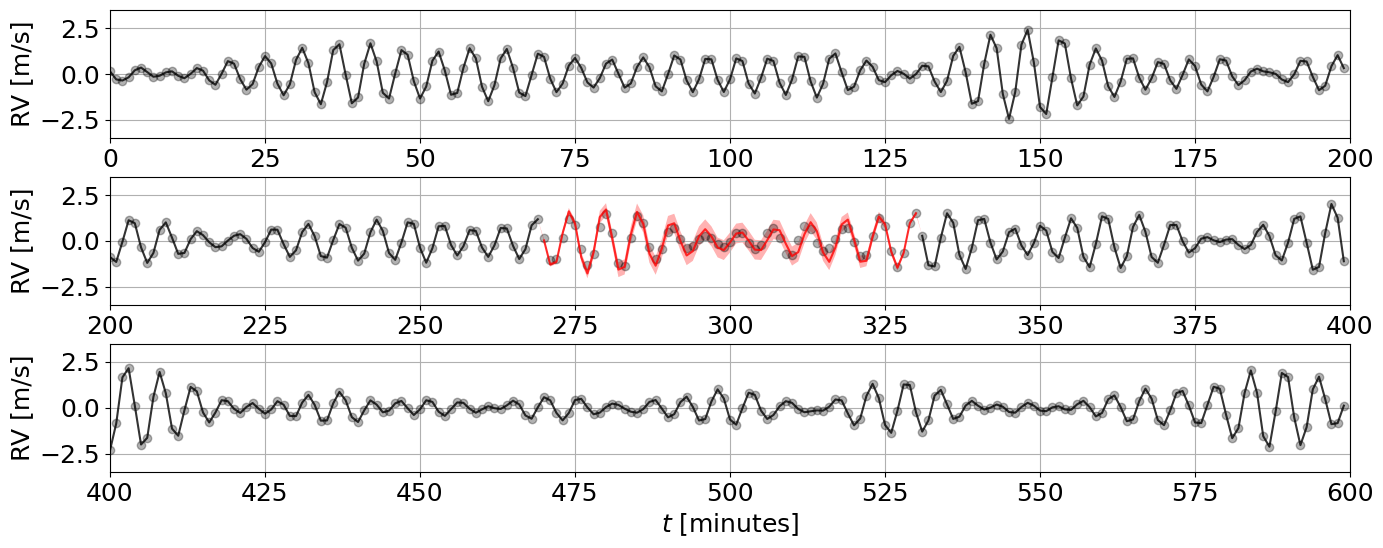

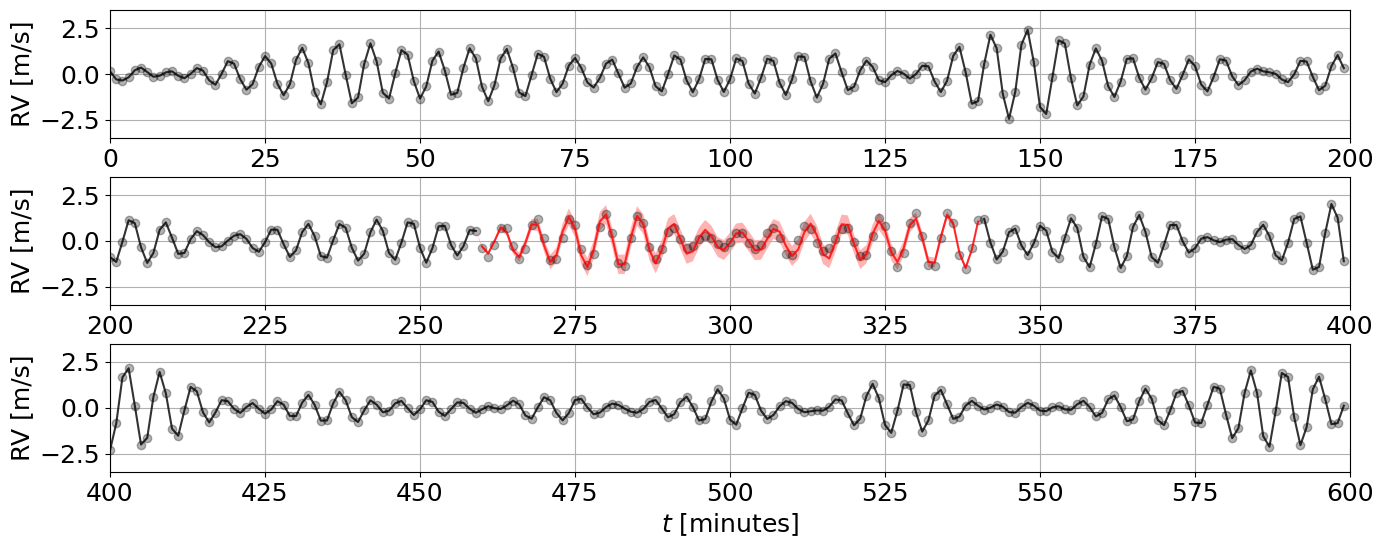

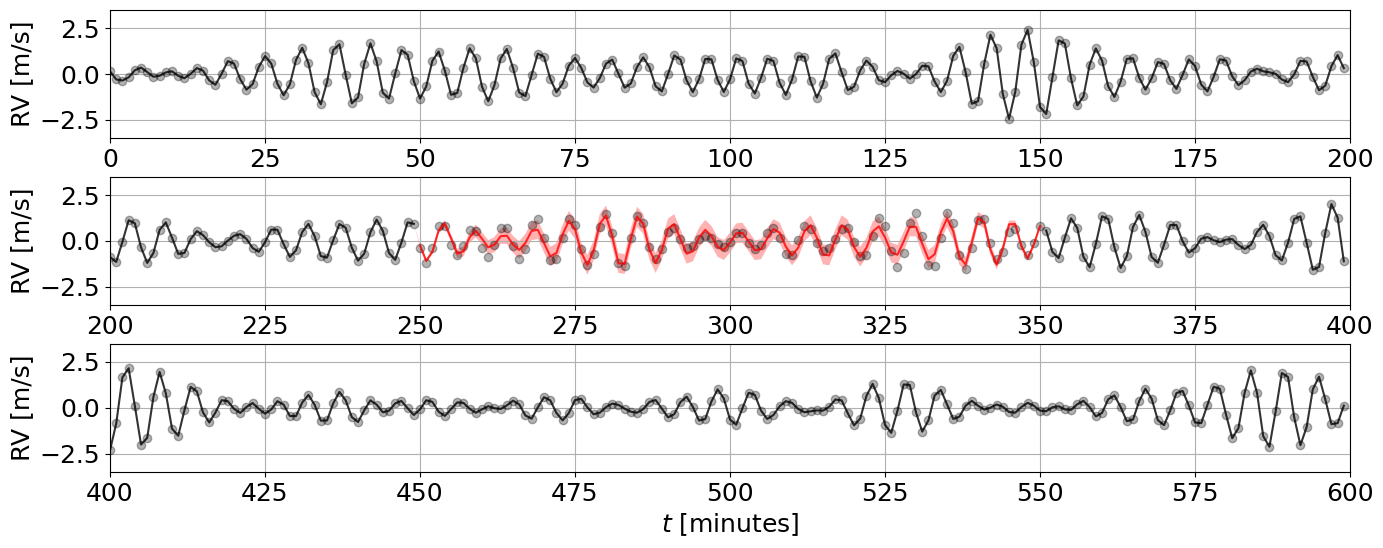

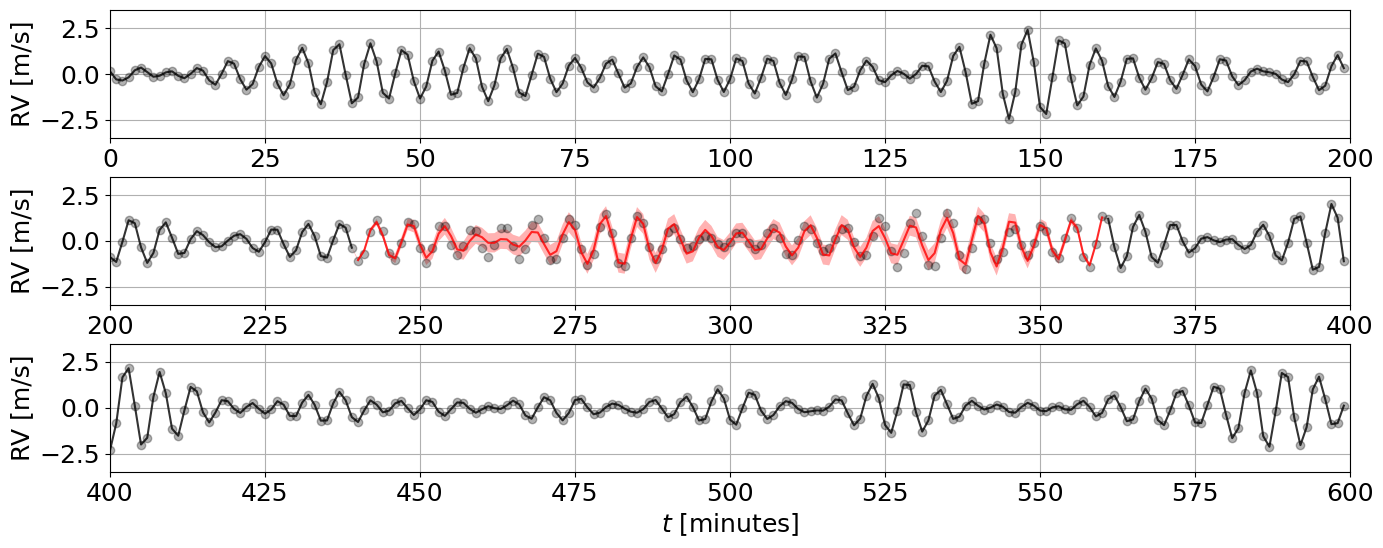

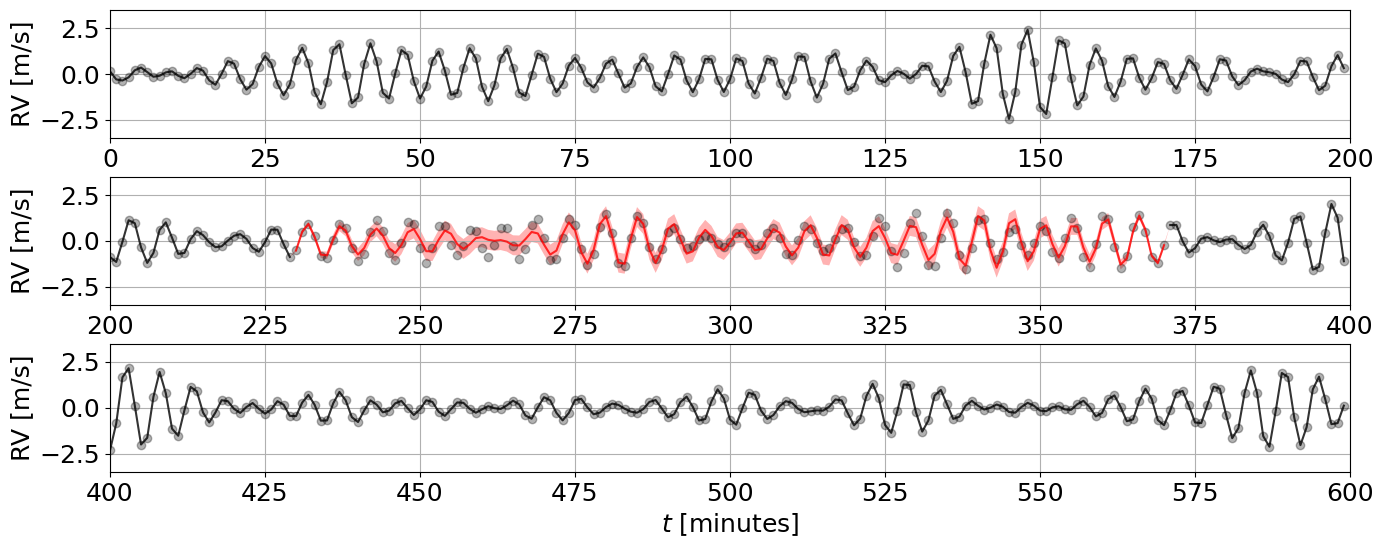

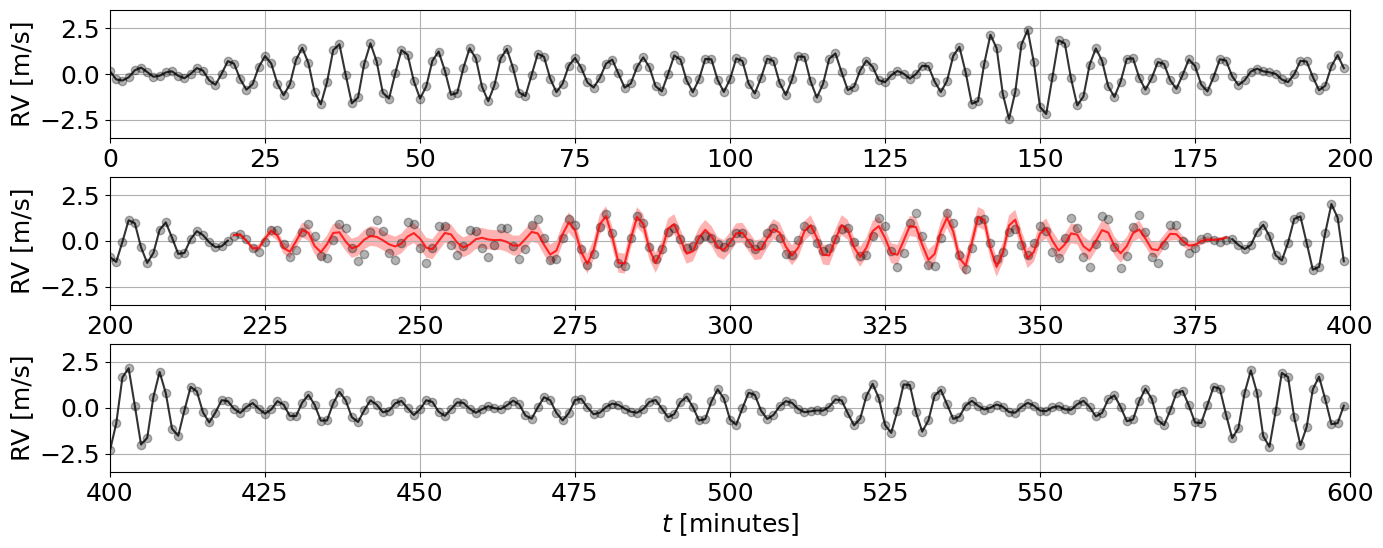

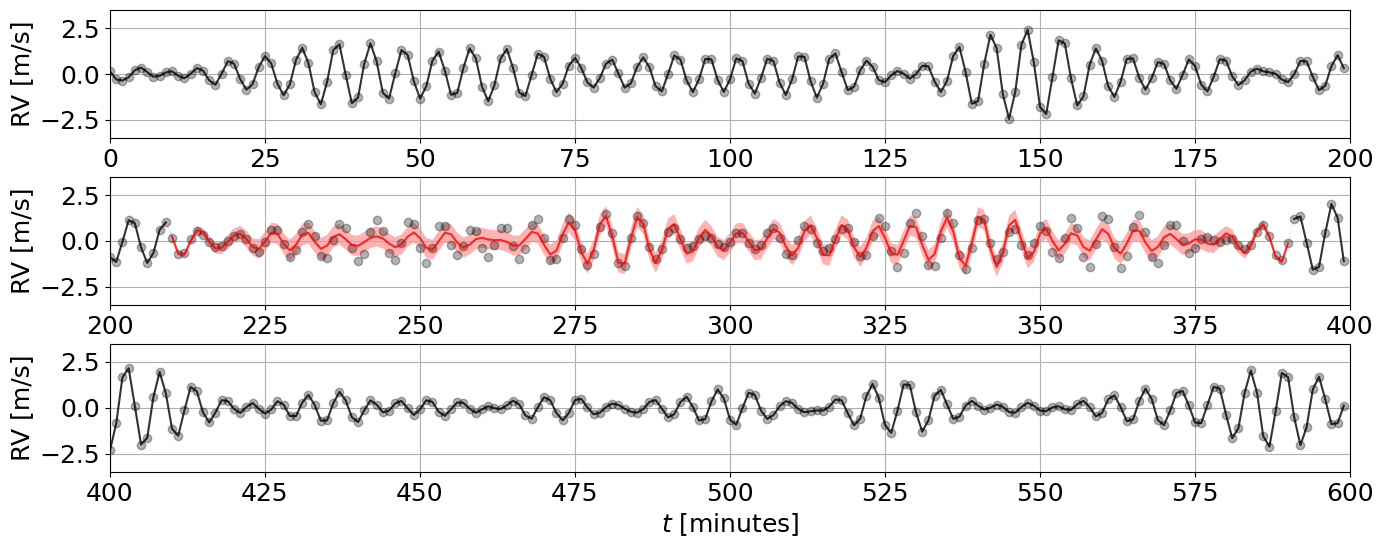

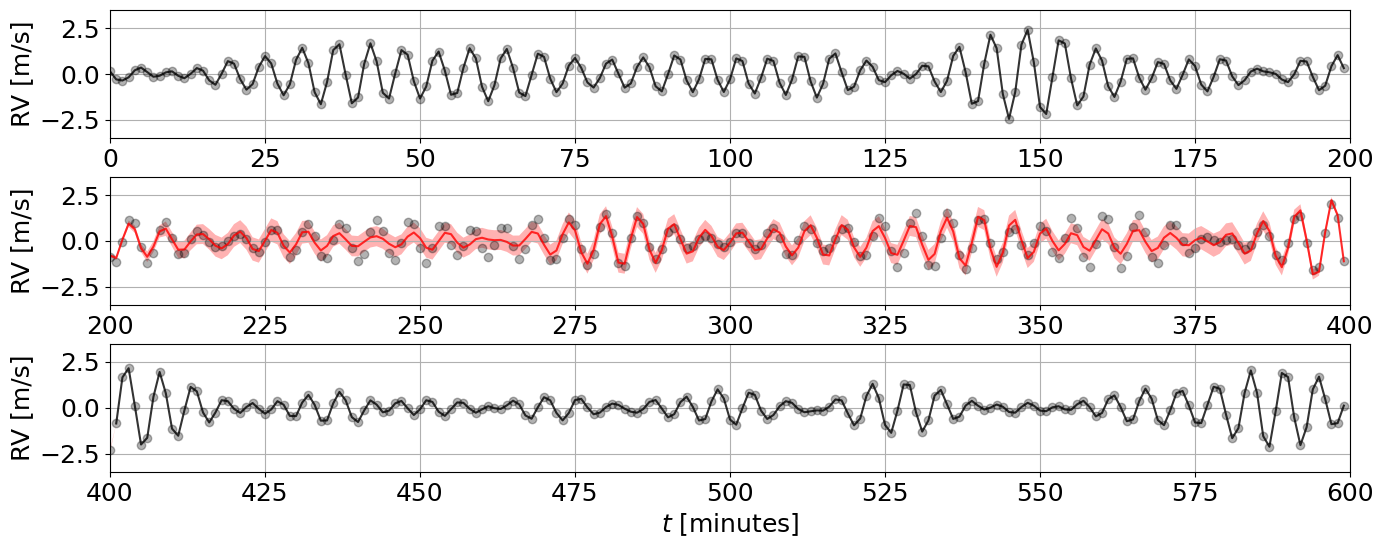

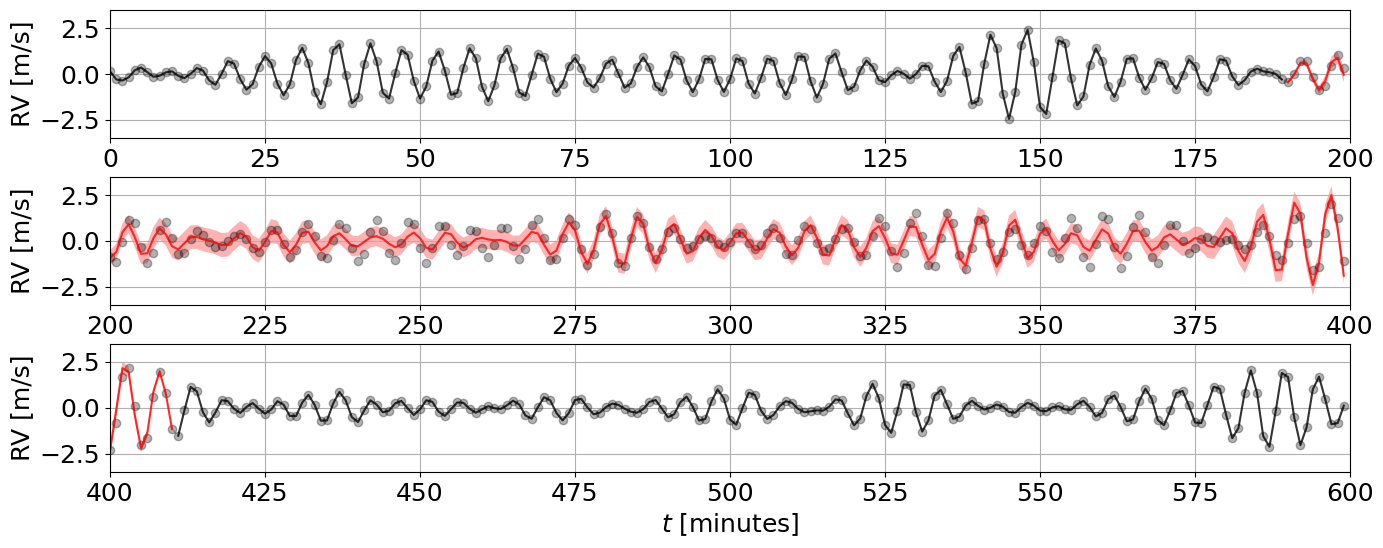

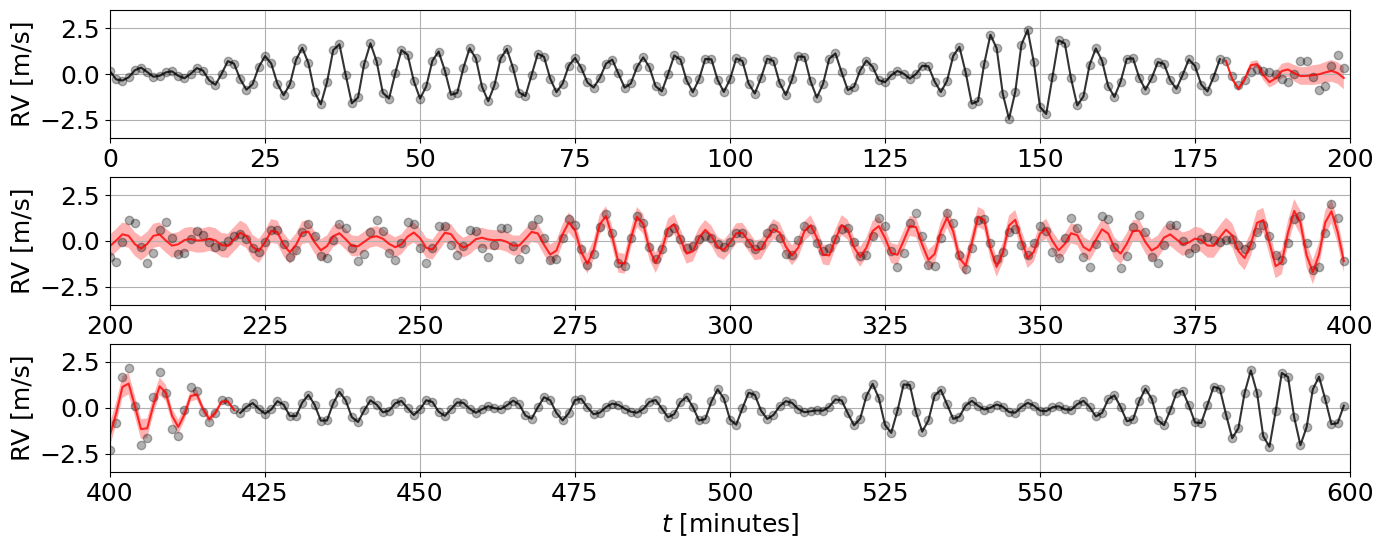

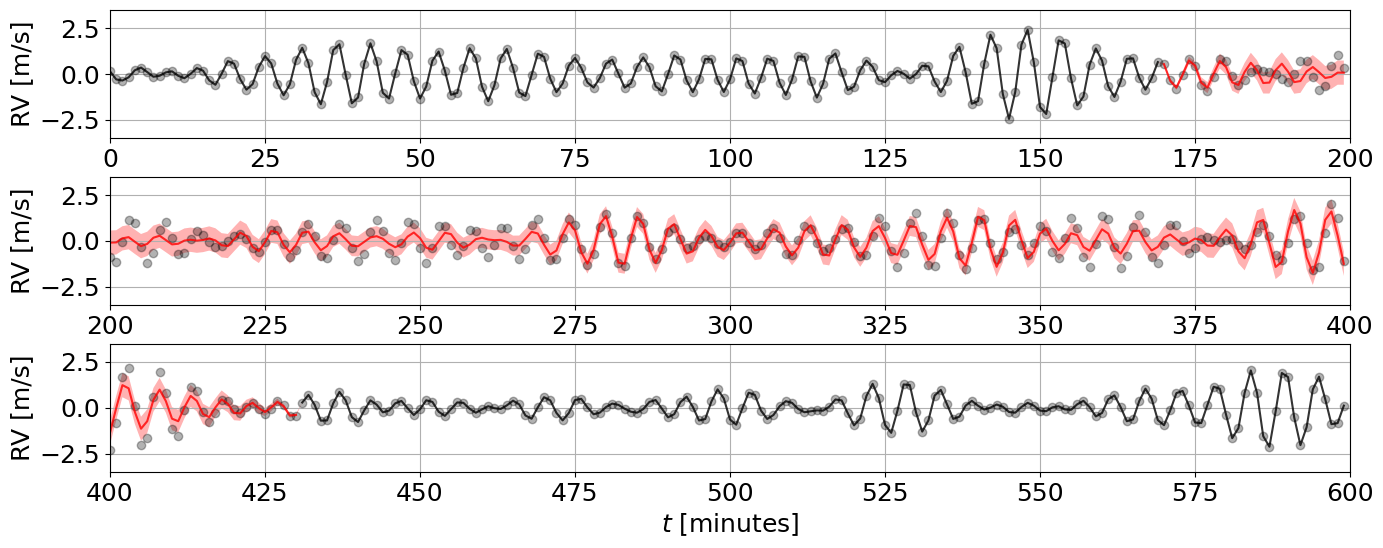

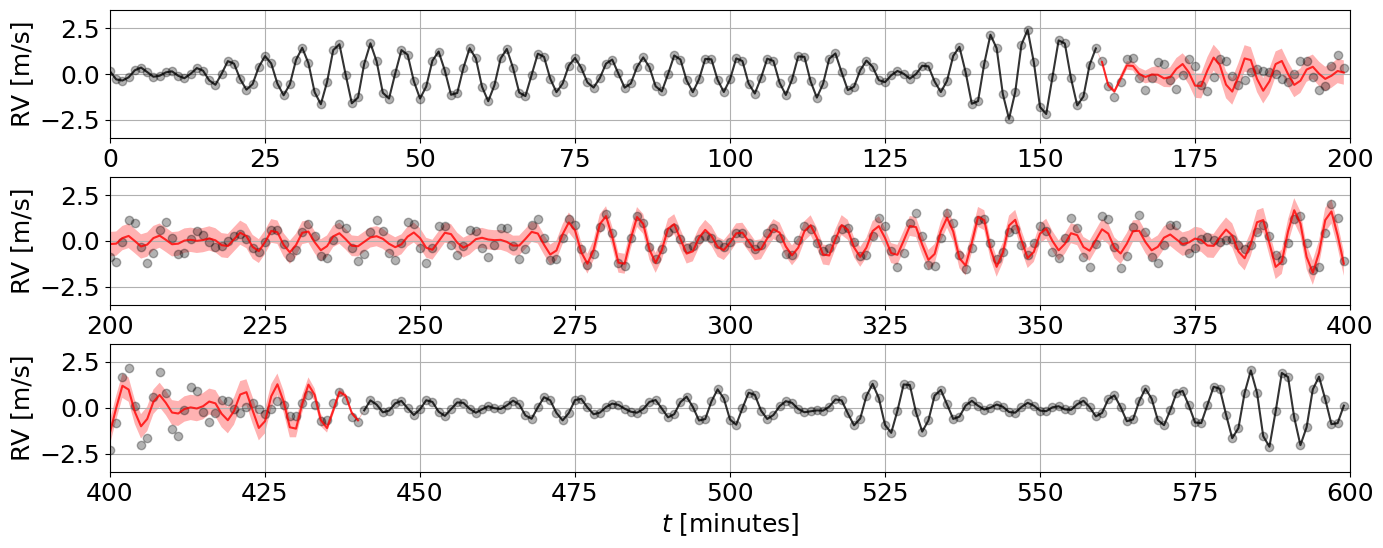

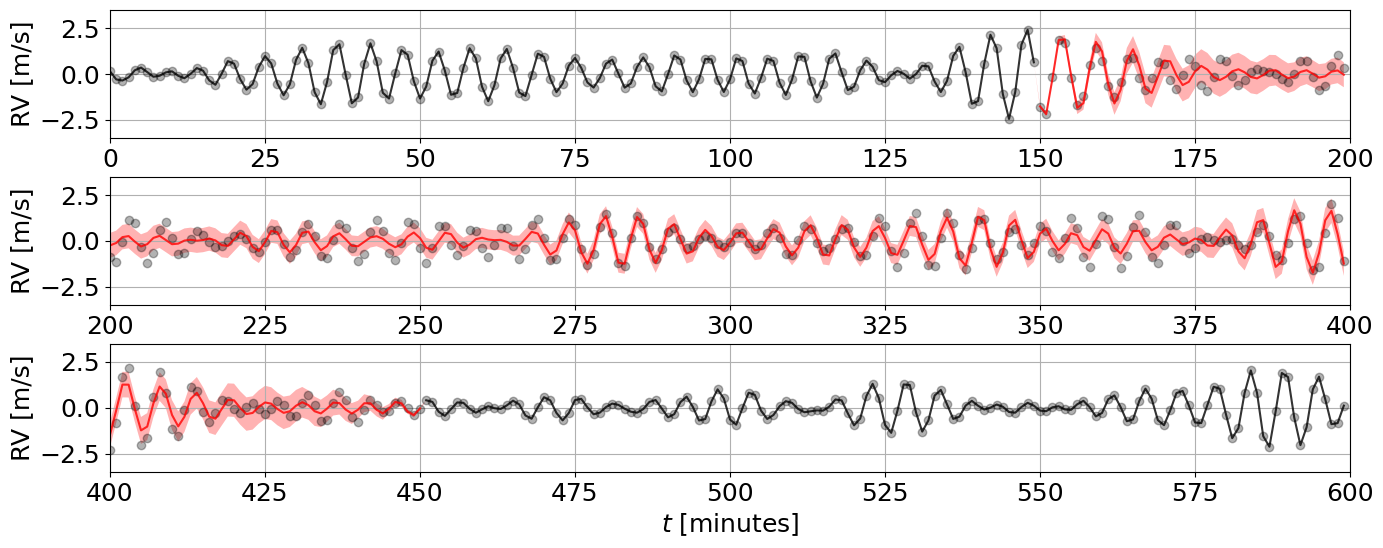

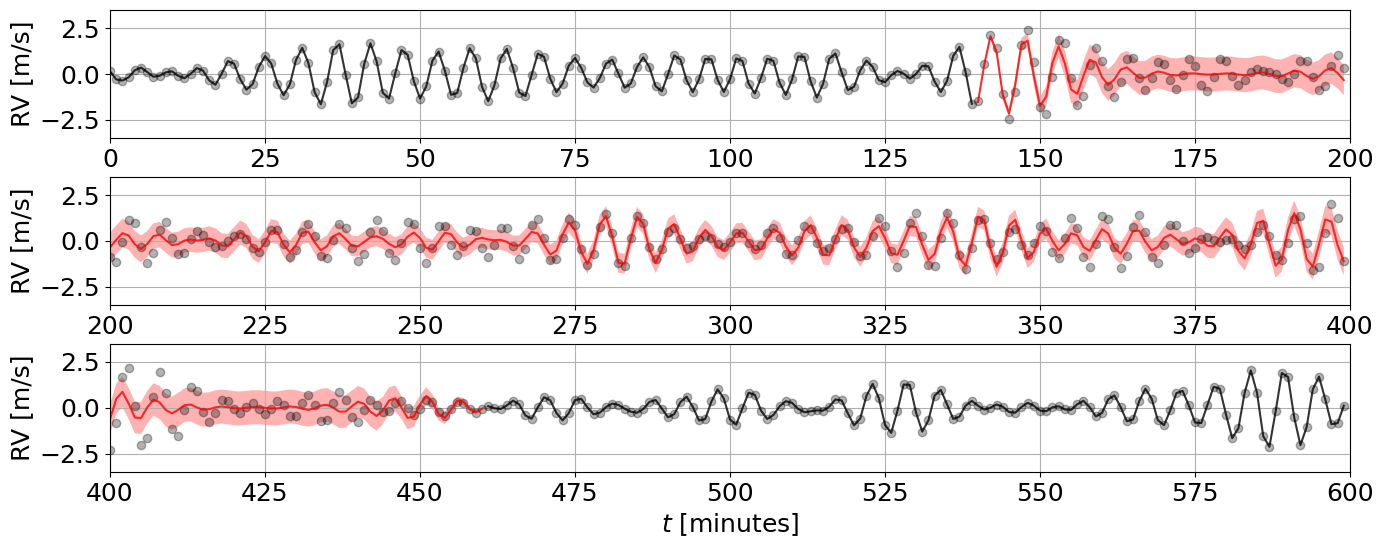

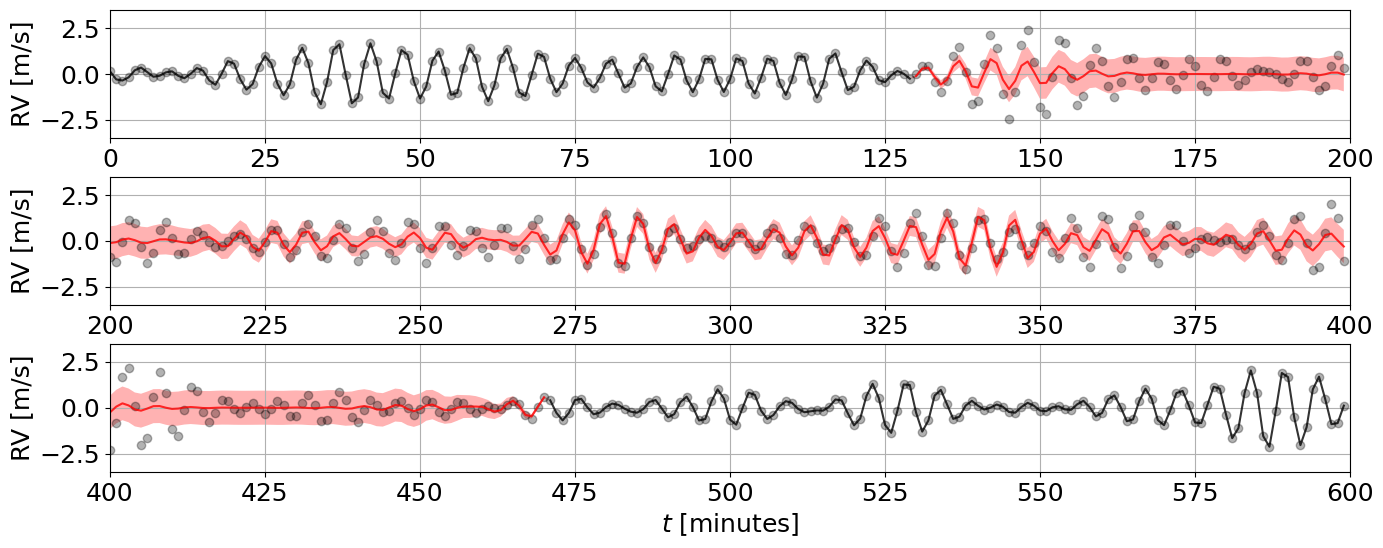

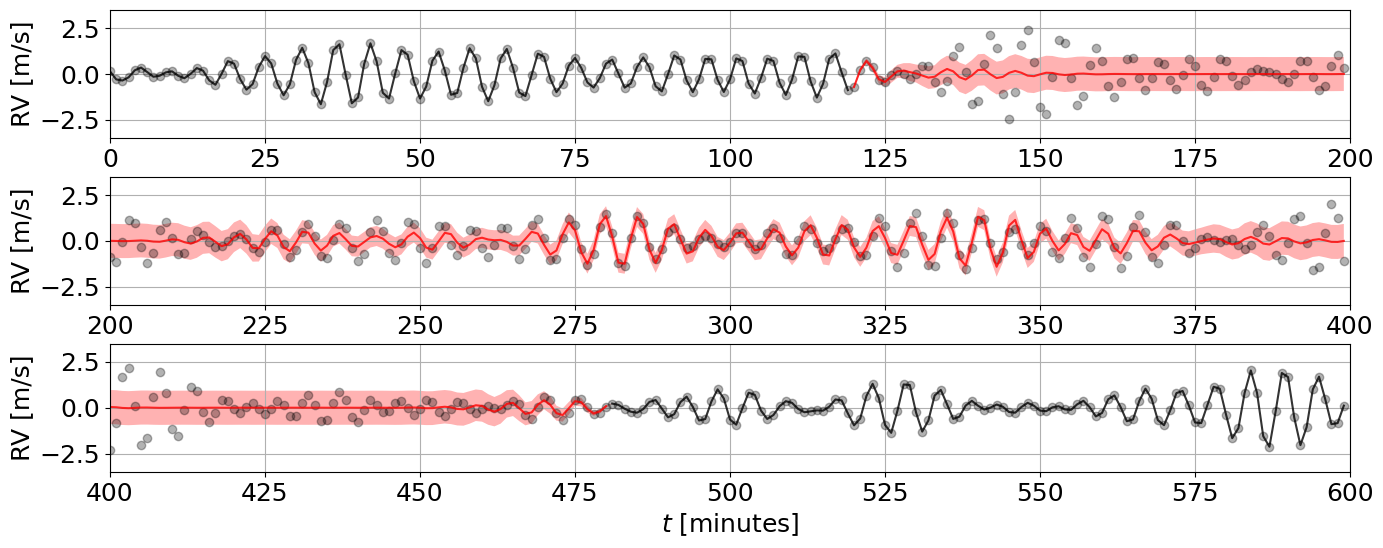

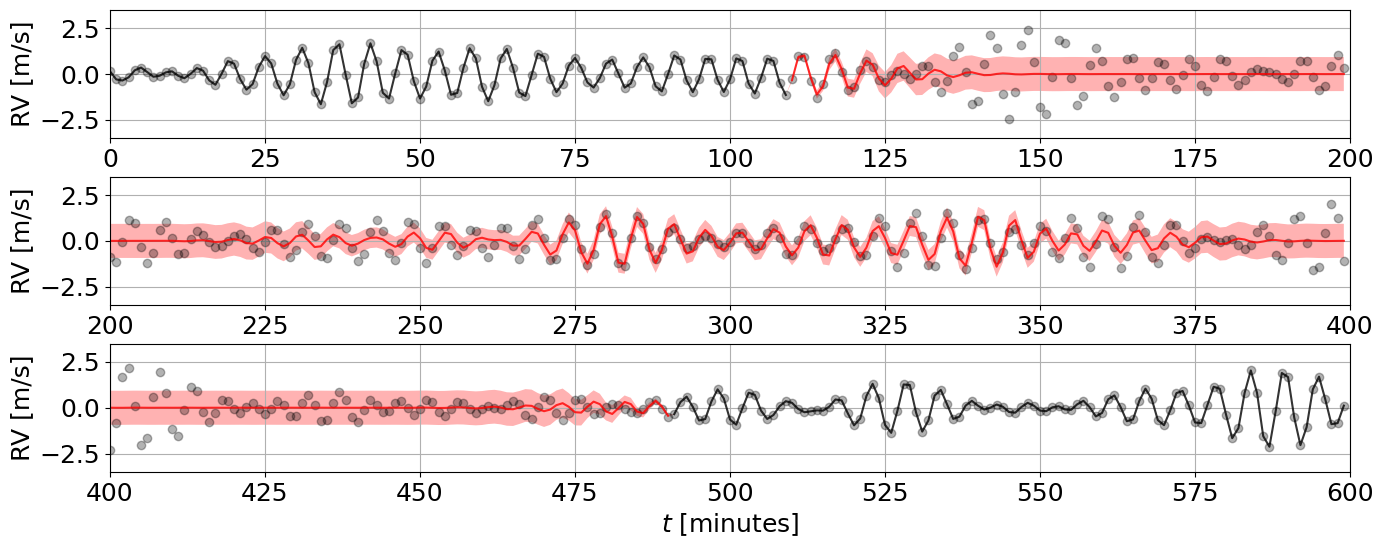

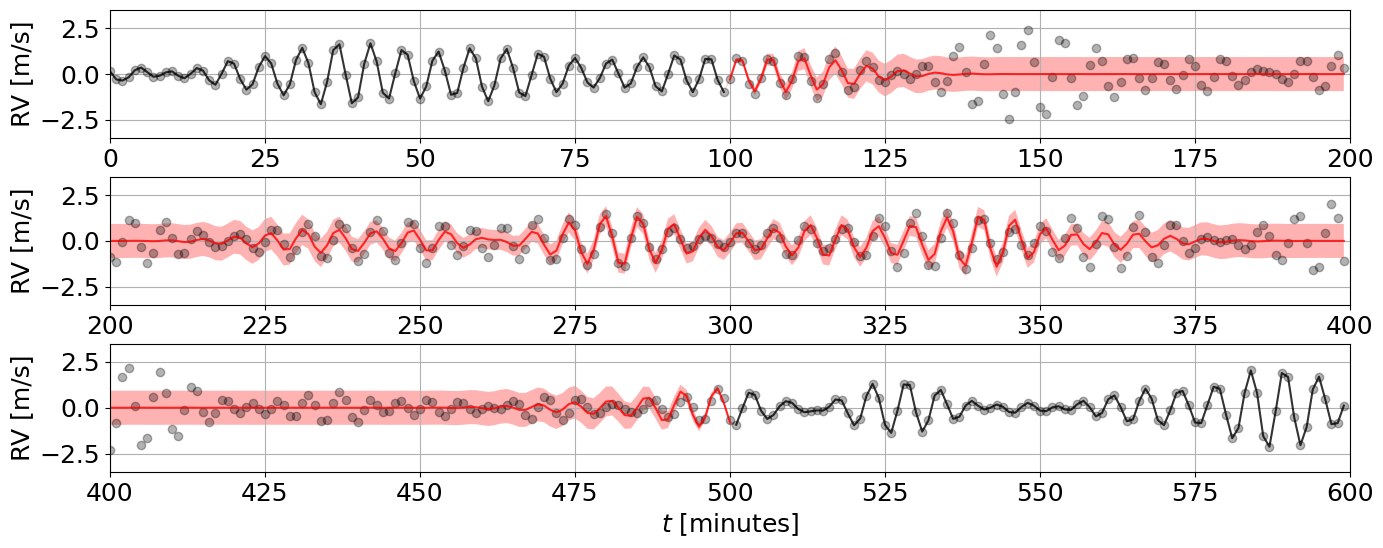

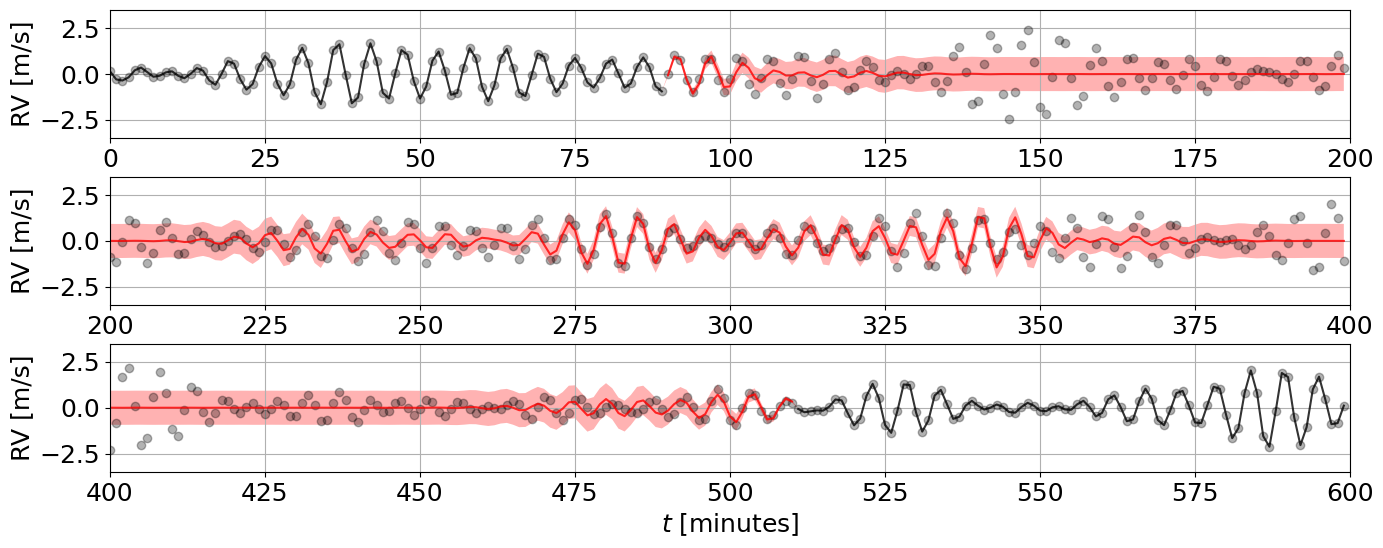

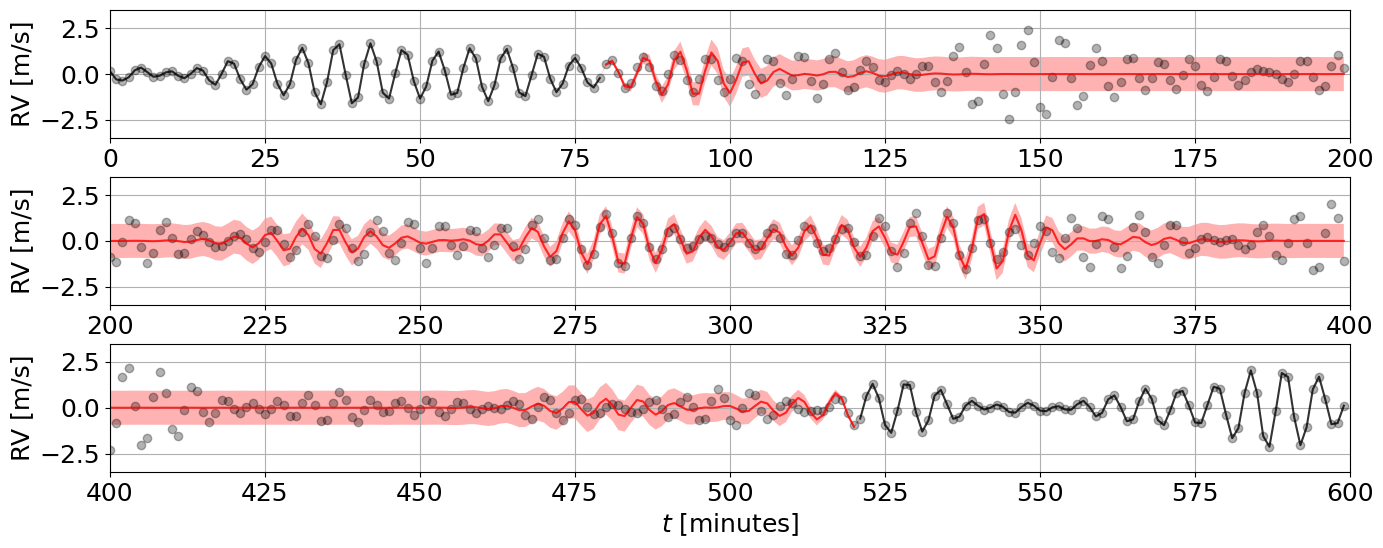

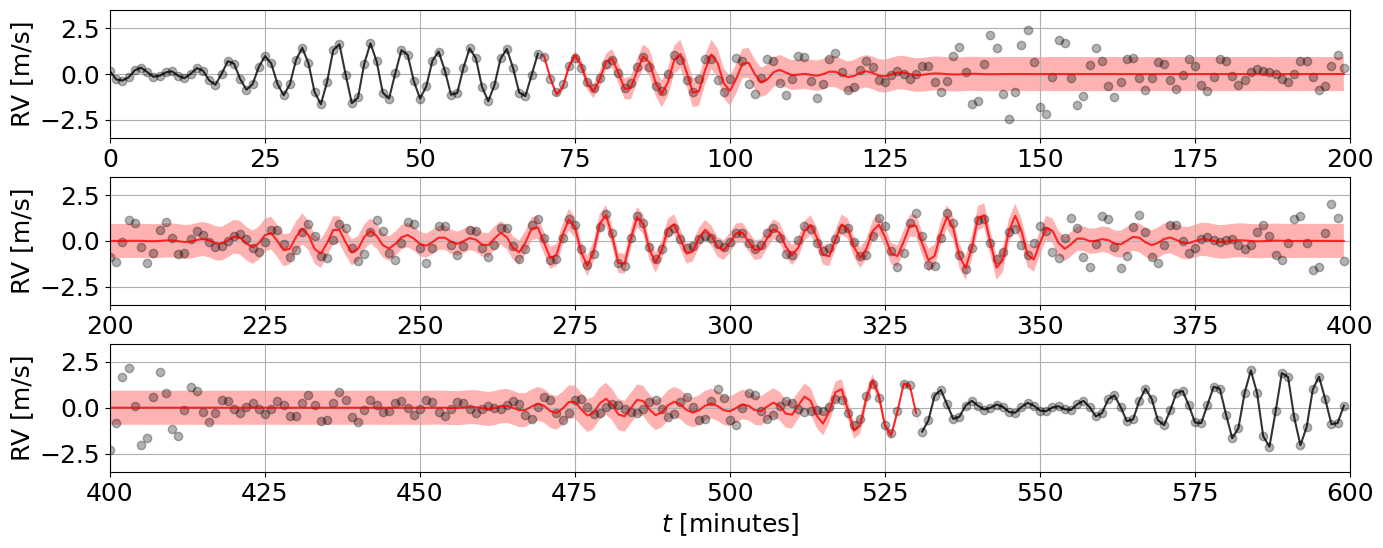

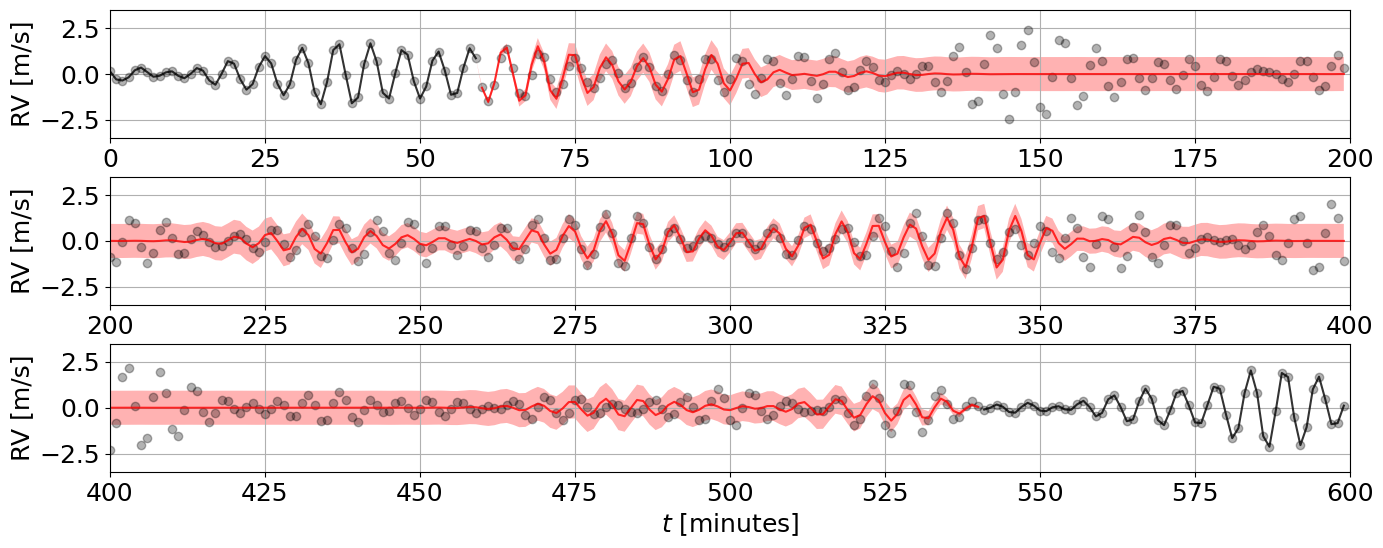

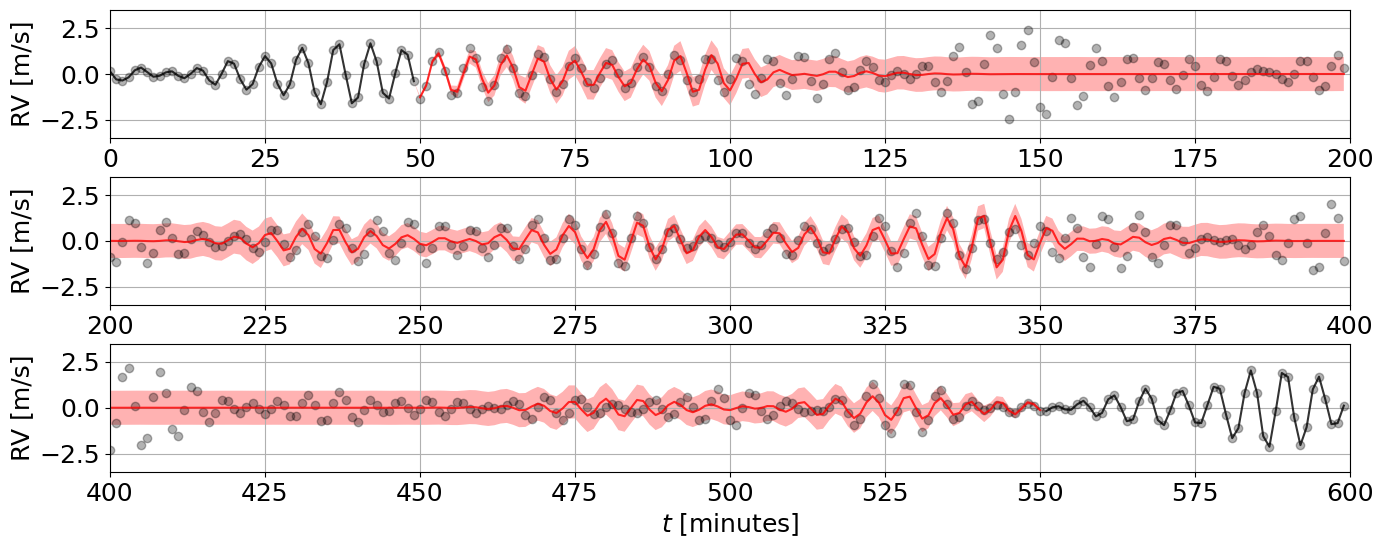

In [15]:
res_rms = []
T_env = 200 

for k in range(26):
    idx_train_1 = (t < 300-10*k)
    idx_train_2 = (t > 300+10*k) 
    idx_train = idx_train_1|idx_train_2
    t_train = t[idx_train]
    y_train = y[idx_train]
    
    gp = GaussianProcess(kernel, t_train)
    cond_gp = gp.condition(y_train, t).gp
    pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5   
    
    fig, axs = plt.subplots(3, 1, figsize=(16, 6))
    plt.subplots_adjust(hspace=0.3)

    for i in range(3):
        idx_t = ((t>=i*T_env) & (t<(i+1)*T_env))
        axs[i].plot(t[idx_t], y[idx_t], 'ko', alpha=0.3)
        axs[i].plot(t[idx_t&idx_train_1], pred_mean[idx_t&idx_train_1], color='k', alpha=0.8)
        axs[i].plot(t[idx_t&idx_train_2], pred_mean[idx_t&idx_train_2], color='k', alpha=0.8)
        axs[i].plot(t[idx_t&~idx_train], pred_mean[idx_t&~idx_train], color='r', alpha=0.8)
        axs[i].fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], 
                            color='r', alpha=0.3, edgecolor="none")
        axs[i].set_ylabel('RV [m/s]')
        axs[i].set_xlim([i*T_env, (i+1)*T_env])
        axs[i].set_ylim([-3.5, 3.5])    
        axs[i].grid(True)
    axs[-1].set_xlabel('$t$ [minutes]')
    plt.savefig('./Figure/GP_recovery_run-19_train-test/' + str(k) + '.png')
    res_rms.append(np.std(pred_mean[~idx_train] - y[~idx_train]))    
    plt.show()

In [16]:
import cv2

img_array = []
for k in range(26):
    filename = './Figure/GP_recovery_run-19_train-test/' + str(k) + '.png'
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('./Video/GP_recovery_run-19_train-test.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


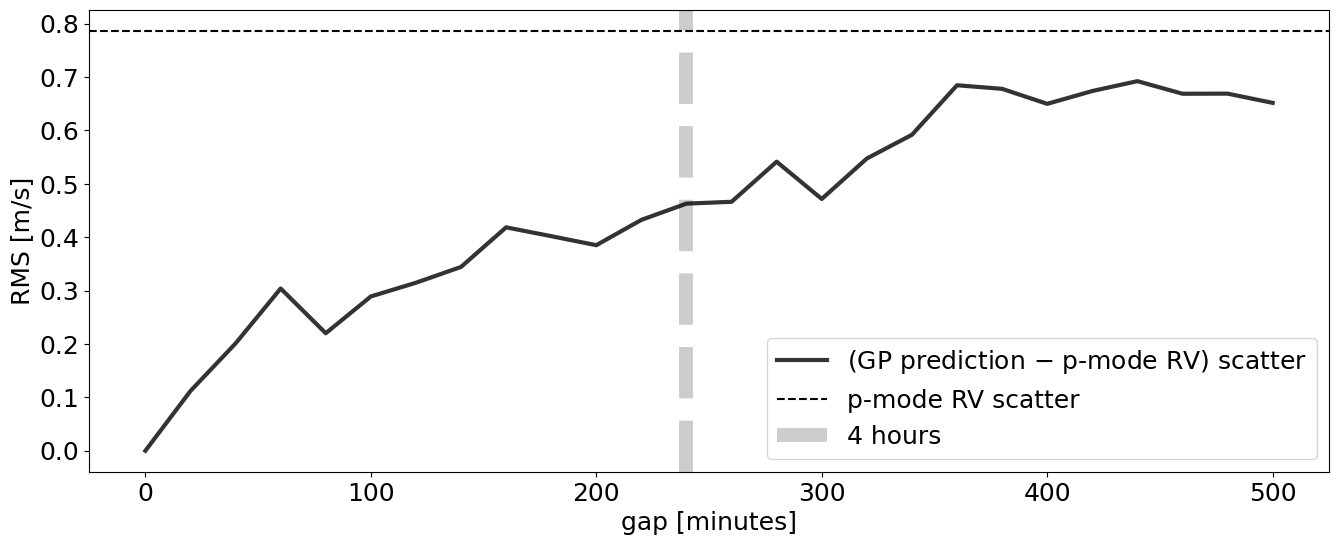

In [17]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(20*np.arange(26), np.array(res_rms), lw=3, color='k', alpha=0.8, label='(GP prediction $-$ p-mode RV) scatter')
plt.axhline(y = np.std(y), color = 'k', linestyle = '--', label='p-mode RV scatter')
plt.axvline(x = 240, color = 'k', lw=10, linestyle = '--', alpha=0.2, label='4 hours')
plt.xlabel('gap [minutes]')
plt.ylabel('RMS [m/s]')
plt.legend()
plt.show()

#### Gapped data at the end

In [18]:
Nr = 1
t = np.linspace(0, 1200, 1201)
gp = GaussianProcess(kernel, t)
y = gp.sample(jax.random.PRNGKey(4), shape=(Nr,))
y = y[0,:]
t.shape, y.shape

((1201,), (1201,))

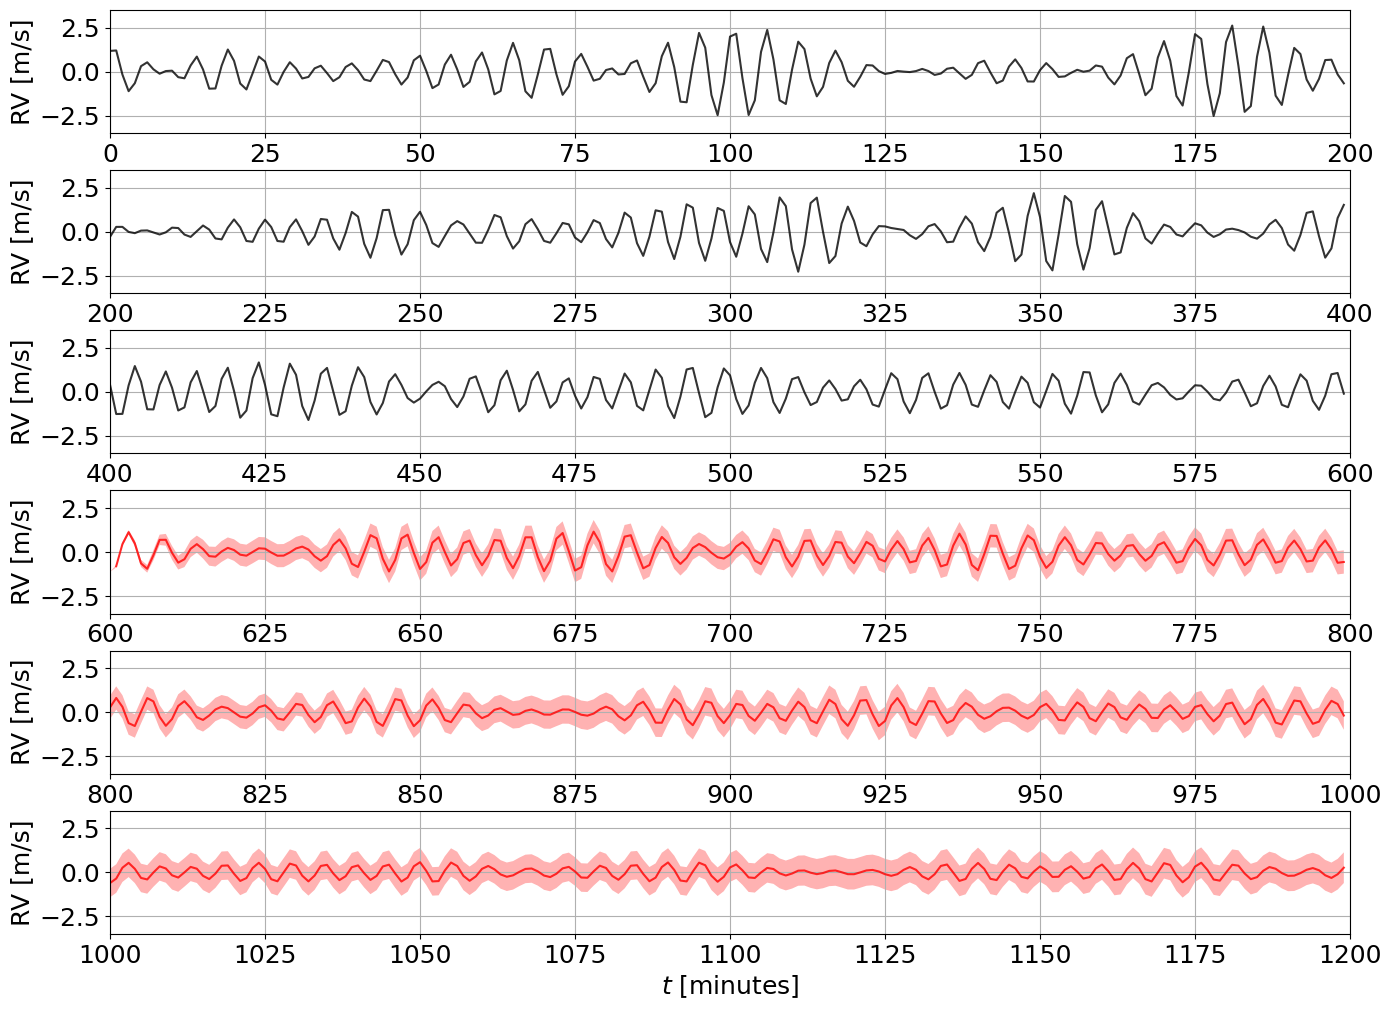

In [19]:
res_rms_edge = []
T_env = 200 

idx_train = (t <= 600) 
t_train = t[idx_train]
y_train = y[idx_train]
gp = GaussianProcess(kernel, t_train)
cond_gp = gp.condition(y_train, t).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5  


fig, axs = plt.subplots(6, 1, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3)
# axs[0].set_title('training data')
for i in range(6):
    idx_t = ((t>=i*T_env) & (t<(i+1)*T_env))
    axs[i].plot(t[idx_t], y[idx_t], 'ko', alpha=0.3)
    axs[i].set_ylabel('RV [m/s]')
    axs[i].set_xlim([i*T_env, (i+1)*T_env])
    axs[i].set_ylim([-3.5, 3.5])    
    axs[i].grid(True)

    axs[i].plot(t[idx_t&idx_train], pred_mean[idx_t&idx_train], color='k', alpha=0.8)
    axs[i].plot(t[idx_t&~idx_train], pred_mean[idx_t&~idx_train], color='r', alpha=0.8)
    axs[i].fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], 
                        color='r', alpha=0.3, edgecolor="none")
    axs[i].set_ylabel('RV [m/s]')
    axs[i].set_xlim([i*T_env, (i+1)*T_env])
    axs[i].set_ylim([-3.5, 3.5])    
    axs[i].grid(True)
        
axs[-1].set_xlabel('$t$ [minutes]')
# plt.savefig('./Figure/GP_recovery_run-19_train-test_edge/' + str(k) + '.png')
# res_rms_edge.append(np.std(pred_mean[~idx_train] - y[~idx_train]))    
plt.show()

In [20]:
res_rms_edge = []
local_res_rms_edge = []

for k in range(31):
    idx_test = (t >= 600) & (t <= 600+20*k) 
    res_rms_edge.append(np.std(pred_mean[idx_test] - y[idx_test]))
    
for k in range(30):    
    idx_test2 = (t > 600+20*k) & (t <= 600+20*(k+1))
    local_res_rms_edge.append(np.std(pred_mean[idx_test2] - y[idx_test2]))

local_res_rms_edge.insert(0, 0)    
res_rms_edge = np.array(res_rms_edge)
local_res_rms_edge = np.array(local_res_rms_edge)

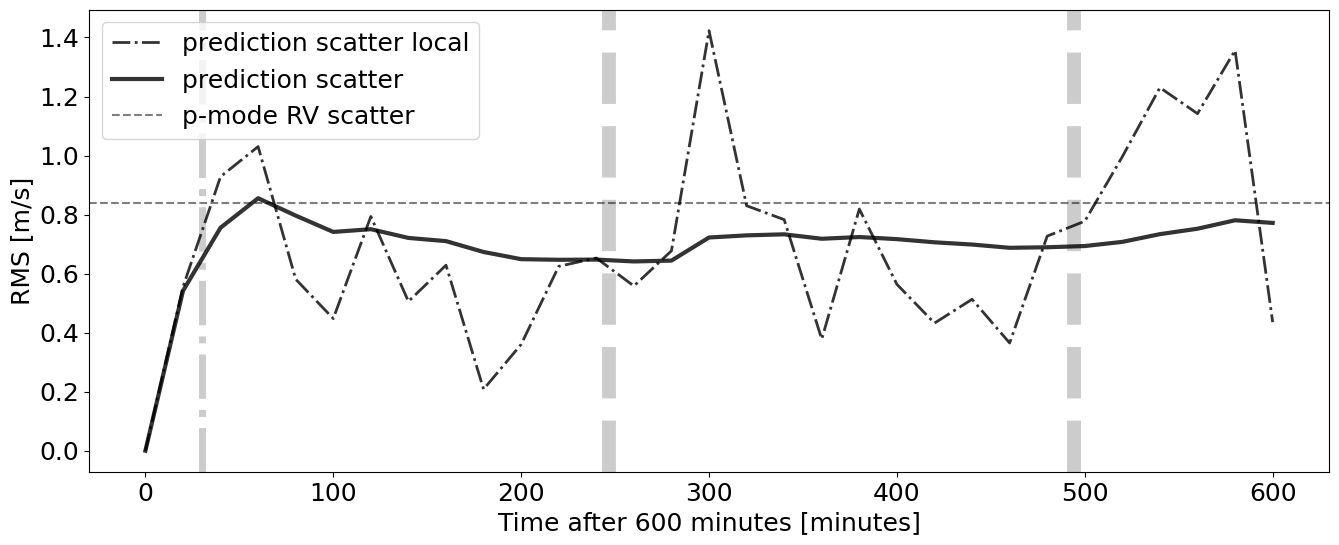

In [21]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(20*np.arange(31), np.array(local_res_rms_edge), lw=2, color='k', ls='-.', alpha=0.8, label='prediction scatter local')
plt.plot(20*np.arange(31), np.array(res_rms_edge), lw=3, color='k', alpha=0.8, label='prediction scatter')
plt.axhline(y = np.std(y), color = 'k', linestyle = '--', label='p-mode RV scatter', alpha=0.5)
plt.axvline(x = 30, color = 'k', lw=5, linestyle = '-.', alpha=0.2, label='')
plt.axvline(x = 247, color = 'k', lw=10, linestyle = '--', alpha=0.2, label='')
plt.axvline(x = 247*2, color = 'k', lw=10, linestyle = '--', alpha=0.2, label='')
plt.xlabel('Time after 600 minutes [minutes]')
plt.ylabel('RMS [m/s]')
plt.legend()
plt.show()

In [22]:
# res_rms_edge = []
# T_env = 200 

# for k in range(26):
#     idx_train = (t < 600-20*k) 
#     t_train = t[idx_train]
#     y_train = y[idx_train]
    
#     gp = GaussianProcess(kernel, t_train)
#     cond_gp = gp.condition(y_train, t).gp
#     pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5   
    
#     fig, axs = plt.subplots(3, 1, figsize=(16, 6))
#     plt.subplots_adjust(hspace=0.3)

#     for i in range(3):
#         idx_t = ((t>=i*T_env) & (t<(i+1)*T_env))
#         axs[i].plot(t[idx_t], y[idx_t], 'ko', alpha=0.3)
#         axs[i].plot(t[idx_t&idx_train], pred_mean[idx_t&idx_train], color='k', alpha=0.8)
#         axs[i].plot(t[idx_t&~idx_train], pred_mean[idx_t&~idx_train], color='r', alpha=0.8)
#         axs[i].fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], 
#                             color='r', alpha=0.3, edgecolor="none")
#         axs[i].set_ylabel('RV [m/s]')
#         axs[i].set_xlim([i*T_env, (i+1)*T_env])
#         axs[i].set_ylim([-3.5, 3.5])    
#         axs[i].grid(True)
#     axs[-1].set_xlabel('$t$ [minutes]')
#     plt.savefig('./Figure/GP_recovery_run-19_train-test_edge/' + str(k) + '.png')
#     res_rms_edge.append(np.std(pred_mean[~idx_train] - y[~idx_train]))    
#     plt.show()

ValueError: x and y must have same first dimension, but have shapes (26,) and (31,)

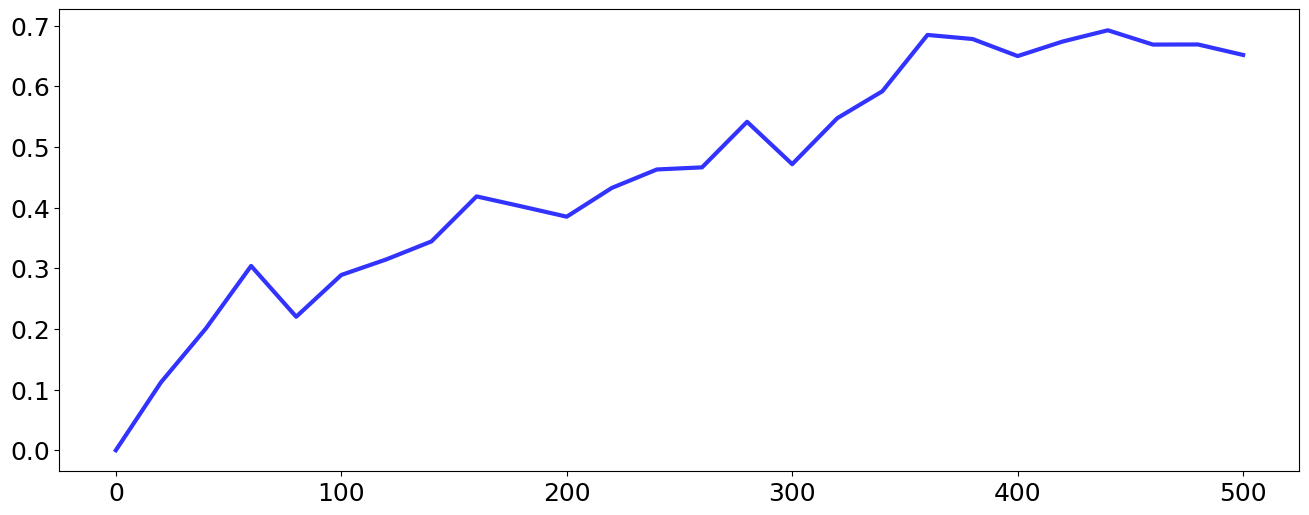

In [23]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(20*np.arange(26), np.array(res_rms), lw=3, color='b', alpha=0.8, label='(GP prediction $-$ p-mode RV) interpolate scatter')
plt.plot(20*np.arange(26), np.array(res_rms_edge), lw=3, color='r', alpha=0.8, label='(GP prediction $-$ p-mode RV) extrapolate scatter')

plt.axhline(y = np.std(y), color = 'k', linestyle = '--', label='p-mode RV scatter')
plt.axvline(x = 240, color = 'k', lw=10, linestyle = '--', alpha=0.2, label='4 hours')
plt.xlabel('gap [minutes]')
plt.ylabel('RMS [m/s]')
plt.legend()
plt.show()

In [ ]:
import cv2

img_array = []
for k in range(26):
    filename = './Figure/GP_recovery_run-19_train-test_edge/' + str(k) + '.png'
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('./Video/GP_recovery_run-19_train-test_edge.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

### parallel computing 

In [ ]:
from multiprocessing import Pool

Nr = 1
t = np.linspace(0, 600, 601)
gp = GaussianProcess(kernel, t)
y = gp.sample(jax.random.PRNGKey(4), shape=(Nr,))
y = y[0,:]


In [ ]:

    
def compute_rms(k):

    idx_train = (t < 600-20*k) 
    t_train = t[idx_train]
    y_train = y[idx_train]
    
    gp = GaussianProcess(kernel, t_train)
    # cond_gp = gp.condition(y_train, t).gp
    pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5   
    
    return np.std(pred_mean[~idx_train] - y[~idx_train])
    # return y_train

# if __name__ == '__main__':
#     k = range(4)
#     with Pool(processes=4) as pool:
#         results = pool.imap(compute_rms, zip(k, [t]*4, [y]*4, [kernel]*4))
#         ordered_results = list(results)
#         print(ordered_results)

# if __name__ == '__main__':
#     k = range(4)
#     with Pool(processes=4) as pool:
#         results = pool.map(compute_rms, [(k_i, t, y, kernel) for k_i in k])
#         print(results)
        
if __name__ == '__main__':
    k = range(4)
    with Pool(processes=4) as pool:
        results = pool.map(compute_rms, k)
        print(results)        

In [ ]:
Nr = 20
t = np.linspace(0, 600, 601)
gp = GaussianProcess(kernel, t)
y = gp.sample(jax.random.PRNGKey(4), shape=(Nr,))

def compute_rms(k):    
    y = y[k,:]

    return y

if __name__ == '__main__':
    k = range(1)
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.map(compute_rms, k)
        print(results)

### Others

In [ ]:
t_int = []
y_int = []
for i in range(2000//(60*8)):
    if i%3 == 0:
        idx =  (t >= i*60*8) & (t < (i+1)*60*8)
        t_int.append(t[idx])
        y_int.append(y[idx])

In [ ]:
t_int = np.array(t_int)
t_int = t_int.flatten()
y_int = np.array(y_int)
y_int = y_int.flatten()

In [ ]:
t_int.shape

In [ ]:
plt.figure(figsize=(16, 4))
plt.title('simulated time-series')
# plt.xlim([0,700])
plt.plot(t, y)
plt.plot(t_int.T, y_int.T, '.')
plt.show()

In [ ]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    # nu_max = jnp.exp(theta["log_nu_max"])
    # A = jnp.exp(theta["log_A"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    # "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    # "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

# Performance

### Q

In [ ]:
def solve():
    w_init = jnp.zeros(len(theta_init))
    lower_bounds = jnp.ones_like(w_init)* (-1)
    upper_bounds = jnp.ones_like(w_init) * jnp.inf
    bounds = (lower_bounds, upper_bounds)

    import jaxopt
    solver = jaxopt.ScipyBoundedMinimize(fun=neg_log_likelihood)
    soln = solver.run(theta_init, bounds=bounds, X=t, y=y)
    print(f"Final negative log likelihood: {soln.state.fun_val}")

    for key, value in soln.params.items():
        print(key[4:], np.exp(value))
    
    model_gp, _ = build_gp(soln.params, t)
    
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(16, 6))
    plt.plot(t, kernel(t, t[:1]), lw=1, color='k', alpha=0.8, label='true kernel')
    plt.plot(t, model_gp.kernel(t, t[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
    plt.title('Kernels')
    plt.xlabel(r'$\Delta t$ [minutes]')
    plt.ylabel(r'Covariance [m$^2$/s$^2$]')
    plt.xlim([0,700])
    plt.legend()
    plt.show()

In [ ]:
 solve()

In [ ]:
idx_test = ((t > 450) & (t < 500))
t_train = t[~idx_test]
y_train = y[~idx_test]

In [ ]:
gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

In [ ]:
for i in range(4):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(t[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t[idx_test], y[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

In [ ]:
idx_test = ((t > 400) & (t < 600))
t_train = t[~idx_test]
y_train = y[~idx_test]

gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(4):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(t[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t[idx_test], y[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

In [ ]:
idx_test = ((t > 500) & (t < 900))
t_train = t[~idx_test]
y_train = y[~idx_test]

gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(6):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(t[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t[idx_test], y[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

In [ ]:
idx_test = ((t > 400) & (t < 600))
t_train = t[~idx_test]
y_train = y[~idx_test]

gp = GaussianProcess(kernel, t_train)
cond_gp = gp.condition(y_train, t).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(4):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(t[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t[idx_test], y[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

In [ ]:
idx_test = ((t > 500) & (t < 900))
t_train = t[~idx_test]
y_train = y[~idx_test]

gp = GaussianProcess(kernel, t_train)
cond_gp = gp.condition(y_train, t).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(6):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(t[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t[idx_test], y[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

### Q, delta_nu

In [ ]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    # nu_max = jnp.exp(theta["log_nu_max"])
    # A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    # "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    # "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

In [ ]:
solve()

### Q, nu_max

In [ ]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    # A = jnp.exp(theta["log_A"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    # "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Q, nu_max, A

In [ ]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

In [ ]:
amp

### Q, nu_max, A, delta_nu

In [ ]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Q, nu_max, A, delta_nu, W

In [ ]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Q, nu_max, A, delta_nu, W, epsilon

In [ ]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])
    epsilon = theta["epsilon"]

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(450),
    "log_A": np.log(0.8*amp),
    "log_W": np.log(350),
    "log_nu_max": np.log(3050),
    "log_delta_nu": np.log(136),
    "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)





In [ ]:
epsilon_l, epsilon_h = jnp.float64([-1, 1])
bounds_l = jnp.log(jnp.array([1e-1,  3e2, 200, 130,  3000.0]))
bounds_h = jnp.log(jnp.array([1,     5e2, 400, 140,  3200.0]))
lower_bounds, upper_bounds = jnp.hstack((epsilon_l, bounds_l)), jnp.hstack((epsilon_h, bounds_h))
bounds = (lower_bounds, upper_bounds)

import jaxopt
solver = jaxopt.ScipyBoundedMinimize(fun=neg_log_likelihood)
# soln = solver.run(theta_init, bounds=bounds, X=t, y=y)
soln = solver.run(theta_init, bounds=bounds, X=t_int, y=y_int)
print(f"Final negative log likelihood: {soln.state.fun_val}")

for key, value in soln.params.items():
    print(key[4:], np.exp(value))

model_gp, _ = build_gp(soln.params, t)

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(t, kernel(t, t[:1]), lw=1, color='k', alpha=0.8, label='true kernel')
plt.plot(t, model_gp.kernel(t, t[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.xlim([0,700])
plt.legend()
plt.show()


In [ ]:
t_kernel = np.linspace(0, 300, 3001)
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(t_kernel, kernel(t_kernel, t_kernel[:1]), lw=1, color='k', alpha=0.8, label='true kernel')
plt.plot(t_kernel, model_gp.kernel(t_kernel, t_kernel[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.xlim([200,300])
plt.legend()
plt.show()

In [ ]:
idx_test = ((t > 500) & (t < 900))
t_train = t[~idx_test]
y_train = y[~idx_test]

gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(6):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(t[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t[idx_test], y[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

In [ ]:
idx_test = ((t_int > 80) & (t_int < 480))
t_train = t_int[~idx_test]
y_train = y_int[~idx_test]

gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t_int).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(3):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t_int>=i*200) & (t_int<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t_int[idx_t], y_int[idx_t], 'k.', alpha=0.1)
    plt.plot(t_int[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t_int[idx_test], y_int[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t_int[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

In [ ]:
np.std(y_int[idx_test] - pred_mean[idx_test])

In [ ]:
idx_test = ((t_int > 80) & (t_int < 400))
t_train = t_int[~idx_test]
y_train = y_int[~idx_test]

gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t_int).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(3):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t_int>=i*200) & (t_int<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t_int[idx_t], y_int[idx_t], 'k.', alpha=0.1)
    plt.plot(t_int[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t_int[idx_test], y_int[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t_int[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

In [ ]:
np.std(y_int[idx_test] - pred_mean[idx_test])

In [ ]:
idx_test = ((t_int > 360) & (t_int < 480))
t_train = t_int[~idx_test]
y_train = y_int[~idx_test]

gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t_int).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(3):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t_int>=i*200) & (t_int<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t_int[idx_t], y_int[idx_t], 'k.', alpha=0.1)
    plt.plot(t_int[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t_int[idx_test], y_int[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t_int[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

In [ ]:
np.std(y_int[idx_test] - pred_mean[idx_test])

In [ ]:
idx_test = ((t_int > 160) & (t_int < 280))
t_train = t_int[~idx_test]
y_train = y_int[~idx_test]

gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t_int).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(3):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t_int>=i*200) & (t_int<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t_int[idx_t], y_int[idx_t], 'k.', alpha=0.1)
    plt.plot(t_int[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t_int[idx_test], y_int[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t_int[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

In [ ]:
np.std(y_int[idx_test] - pred_mean[idx_test])

In [ ]:
np.std(y[idx_test] - pred_mean[idx_test])

### +diag

In [ ]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])
    epsilon = theta["epsilon"]

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)

    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"])), kernel           

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Cov

In [ ]:
t = np.linspace(0, 3000, 3001)
y_data = kernel(t, t[:1])[:,0]

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(t, y_data, lw=1, color='k', alpha=0.8, label='true kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.xlim([0,800])
plt.legend()
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))

idx_y = (abs(y_data)>np.std(y_data)/3)
plt.plot(t[idx_y], y_data[idx_y], 'o', lw=1, color='r', alpha=0.8)
plt.plot(t, y_data, lw=1, color='k', alpha=0.8, label='true kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
# plt.xlim([0,800])
plt.legend()
plt.show()

In [ ]:
epsilon, Q, N

In [ ]:
idx = (t<=550)
t = t[idx]
y_data = y_data[idx]

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))

idx_y = (abs(y_data)>np.std(y_data)/3)
plt.plot(t[idx_y], y_data[idx_y], 'o', lw=1, color='r', alpha=0.8)
plt.plot(t, y_data, lw=1, color='k', alpha=0.8, label='true kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
# plt.xlim([0,800])
plt.legend()
plt.show()

In [ ]:
def build_kernal(theta):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])
    epsilon = theta["epsilon"]

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)

    return kernel           

# GaussianProcess(
#         kernel, X, diag=jnp.exp(theta["log_diag"]))

def cov_rms(theta, y):
    kernel_model = build_kernal(theta)
    # gp, _ = build_kernal(theta, X)
    rms = jnp.sum((kernel_model(t, t[:1])[:,0] - y)**2)**0.5
    return rms



# def cov_rms(theta, X, y):
#     gp, _ = build_gp(theta, X)
#     rms = jnp.sum((gp(t, t[:1]) - kernel(t, t[:1]))**2)**0.5
#     return rms

theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(420),
    "log_A": np.log(0.8*amp),
    "log_W": np.log(350),
    "log_nu_max": np.log(3050),
    "log_delta_nu": np.log(136),
    "epsilon": np.float64(0.0)
}

In [ ]:
# w_init = jnp.zeros(len(theta_init))
# lower_bounds = jnp.ones_like(w_init)* (-1.5)
# upper_bounds = jnp.ones_like(w_init) * jnp.inf
# bounds = (lower_bounds, upper_bounds)

epsilon_l, epsilon_h = jnp.float64([-1, 1])
bounds_l = jnp.log(jnp.array([1e-1,  3e2, 200, 130,  3000.0]))
bounds_h = jnp.log(jnp.array([1,     5e2, 400, 140,  3200.0]))
lower_bounds, upper_bounds = jnp.hstack((epsilon_l, bounds_l)), jnp.hstack((epsilon_h, bounds_h))
bounds = (lower_bounds, upper_bounds)

import jaxopt
solver = jaxopt.ScipyBoundedMinimize(fun=cov_rms, maxiter=10000) #
soln = solver.run(theta_init, bounds=bounds, y=y_data)
print(f"Final negative log likelihood: {soln.state.fun_val}")

for key, value in soln.params.items():
    print(key[4:], np.exp(value))

# model_gp, _ = build_gp(soln.params, t)

In [ ]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(t, y_data, lw=1, color='k', alpha=0.8, label='true kernel')
plt.plot(t, build_kernal(soln.params)(t, t[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
# plt.xlim([0,700])
plt.legend()
plt.show()

In [ ]:
# plt.rcParams.update({'font.size': 18})
# fig = plt.figure(figsize=(16, 6))
# plt.plot(t, y_data, lw=1, color='k', alpha=0.8, label='true kernel')
# plt.plot(t, build_kernal(soln.params)(t, t[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
# plt.title('Kernels')
# plt.xlabel(r'$\Delta t$ [minutes]')
# plt.ylabel(r'Covariance [m$^2$/s$^2$]')
# # plt.xlim([700,1400])
# plt.xlim([0,700])
# plt.legend()
# plt.show()

In [ ]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(t, y_data, lw=1, color='k', alpha=0.8, label='true kernel')
plt.plot(t, build_kernal(soln.params)(t, t[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
plt.xlim([200,300])
plt.legend()
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(16, 6))
plt.plot(t, y_data- build_kernal(soln.params)(t, t[:1])[:,0], '-', lw=1, color='k', alpha=0.8, label='diff kernel')
# plt.plot(t, build_kernal(soln.params)(t, t[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
plt.title('Kernels')
plt.xlabel(r'$\Delta t$ [minutes]')
plt.ylabel(r'Covariance [m$^2$/s$^2$]')
# plt.xlim([700,1400])
plt.xlim([0,700])
plt.legend()
plt.show()

In [ ]:
# build_kernal(soln.params)(t, t[:1])[:,0][idx_y] - y_data[idx_y]

In [ ]:
cov_rms(soln.params, y_data)

In [ ]:
t = np.linspace(0, 3000, 3001)

idx_test = ((t > 500) & (t < 900))
t_train = t[~idx_test]
y_train = y[~idx_test]

gp, _ = build_gp(soln.params, t_train)
cond_gp = gp.condition(y_train, t).gp
pred_mean, pred_std = cond_gp.loc, cond_gp.variance**0.5

for i in range(6):
    fig = plt.figure(figsize=(16, 2))
    idx_t = ((t>=i*200) & (t<(i+1)*200))
    # idx_x = ((x>=i*200) & (x<(i+1)*200))
    plt.plot(t[idx_t], y[idx_t], 'k.', alpha=0.1)
    plt.plot(t[idx_t], pred_mean[idx_t], color='k', alpha=0.8)
    plt.plot(t[idx_test], y[idx_test], 'o', color='r', alpha=0.3)
    plt.fill_between(t[idx_t], pred_mean[idx_t]+pred_std[idx_t], pred_mean[idx_t]-pred_std[idx_t], color='k', alpha=0.2,
                     edgecolor="none")
    plt.xlabel('t [minute]')
    plt.ylabel('RV [m/s]')
    plt.xlim([i*200, (i+1)*200])
    plt.ylim([-2.5, 2.5])
    plt.show()

In [ ]:
np.std(y[idx_test] - pred_mean[idx_test])